## Initial settings (authorize, connect GD, install packages, etc)

In [ ]:
# @title get GEE authorization
import ee

# Trigger the authentication flow.
ee.Authenticate()
# Initialize the library.
ee.Initialize(project='ee-scai62')

In [ ]:
# @title Connect to my Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/' .
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/EnKF/LGAR' .
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/EnKF/LGAR_EnKF' .
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/EnKF/settingInfo.txt' .
!cp -r '/content/gdrive/My Drive/NIFA_Download/StartFolder/EnKF/vG_default_params_HYDRUS.csv' .

In [ ]:
# @title Install necessary packages
!pip install folium
!pip install geopandas
!pip install netCDF4
!pip install --upgrade xee
!pip install rasterio
!pip install ipywidgets
!pip install permetrics==2.0.0
!pip install pyDEM
# !pip install richdem
!pip install pyflwdir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 4.1 MB/s eta 0:00:00
  Created wheel for pyDEM: filename=pyDEM-1.1.0-cp311-cp311-linux_x86_64.whl size=281431 sha256=09a4dbe5a8dc57e409b81617de6a6877b9498e6dab6d16008d76bdcb0e352e80
  Stored in dir

In [ ]:
# @title Import packages
import folium
from folium import Figure
import geopandas as gpd
import json
import geemap
import numpy as np
from shapely.geometry import mapping
import pandas as pd
import netCDF4 as nc
import xarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
import math
import time
import os
from datetime import datetime, timedelta
import joblib
import ipywidgets as widgets
from IPython.display import display
from permetrics import RegressionMetric
import osgeo.gdal as gdal
# import richdem as rd
import pyflwdir
from osgeo import osr, gdalconst
from scipy.stats import rankdata

## Define study site: set longitude and latitude

In [ ]:
# @title Input longitude and latitude

global lon, lat
lon, lat = None, None

def validate_coordinates(lon, lat):
    return -125 <= lon <= -66 and 24 <= lat <= 50

def on_button_click(b):
    global lon, lat
    try:
        lon = float(longitude_input.value)
        lat = float(latitude_input.value)
        if validate_coordinates(lon, lat):
            output_area.clear_output()
            with output_area:
                print(f"Valid coordinates: Longitude {lon}, Latitude {lat}")
        else:
            output_area.clear_output()
            with output_area:
                print("Invalid coordinates. Please enter values within the contiguous USA.")
    except ValueError:
        output_area.clear_output()
        with output_area:
            print("Invalid input. Please enter numeric values.")

longitude_input = widgets.Text(placeholder="Enter Longitude")
latitude_input = widgets.Text(placeholder="Enter Latitude")
submit_button = widgets.Button(description="OK")
output_area = widgets.Output()

submit_button.on_click(on_button_click)

display(widgets.HBox([widgets.Label("Longitude:"), longitude_input]))
display(widgets.HBox([widgets.Label("Latitude:"), latitude_input]))
display(submit_button)
display(output_area)

# test: Lon: Text(value=' -89.35613412', placeholder='Enter Longitude')
# Text(value=' 40.66050086', placeholder='Enter Latitude')

Button(description='OK', style=ButtonStyle())

Output()

In [ ]:
# @title Store in form of list
id_list = [0]
lat_list = [lat]
lon_list = [lon]
print(id_list)
print(lat_list)
print(lon_list)

[0]
[40.66050086]
[-89.35613412]


In [ ]:
# @title Define feature collection: points ID, longitude, and latitude
lons_sub = ee.List(lon_list)
lats_sub = ee.List(lat_list)
idnum_sub = ee.List(id_list)
points = lons_sub.zip(lats_sub).zip(idnum_sub).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection = ee.FeatureCollection(points)

In [ ]:
feature_collection.getInfo()

{'type': 'FeatureCollection',
 'columns': {'id_num': 'Integer', 'system:index': 'String'},
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Point', 'coordinates': [-89.35613412, 40.66050086]},
   'id': '0',
   'properties': {'id_num': 0}}]}

In [ ]:
# @title Visualization - spatial distribution of sites
import folium
from folium import Figure

fig = Figure(width=800, height=600)
m = folium.Map(location=[42, -95.25], zoom_start=4)


roi_geojson = feature_collection.getInfo()
folium.TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='Google Satellite',
    name='Satellite',
    overlay=True
).add_to(m)
folium.GeoJson(roi_geojson).add_to(m)

fig.add_child(m)

## Read ee.images (constant images)

In [ ]:
# @title Get TWI - predefine functions

def set_nodata_value(raster_file, nodata_value):
    # Open the raster file in read mode
    with rasterio.open(raster_file) as src:
        # Copy the metadata of the source raster
        meta = src.meta.copy()
        # Read the data
        data = src.read()

    # Set the nodata value
    meta.update(nodata=nodata_value)

    # Open the raster in write mode and overwrite the existing file
    with rasterio.open(raster_file, 'w', **meta) as dst:
        # Write the data to the same raster with the updated metadata
        dst.write(data)

def readRaster(filename):
    dataset=gdal.Open(filename, gdal.GA_ReadOnly)
    if not dataset:
        print("false")
        return 0,0
    else:
        band=dataset.GetRasterBand(1)
        arr = band.ReadAsArray()
        return np.array(arr), band.GetNoDataValue(),dataset.GetProjectionRef(),dataset.GetGeoTransform()

def arr2raster(filename,arr,proj,transform):
    driver = gdal.GetDriverByName("GTiff")
    etype = gdal.GDT_Float32
    # no_data_value = ''
    ds = driver.Create(filename, len(arr[0]), len(arr), 1, etype)
    ds.SetGeoTransform(transform)
    ds.SetProjection(proj)
    # ds.SetMetadataItem("NODATA_VALUES", "-3.40282346639e+038")
    # ds.GetRasterBand(1).SetNoDataValue(-1)
    ds.GetRasterBand(1).WriteArray(arr)
    return


def surface_area(phi_a, phi_b, lambda_c, lambda_d):
    # this function from : https://github.com/chaneyn/geospatialtools.git
    Re = 6371000.0   # m
    #Convert to radians
    phi_a = phi_a*np.pi/180.0
    phi_b = phi_b*np.pi/180.0
    lambda_c = lambda_c*np.pi/180.0
    lambda_d = lambda_d*np.pi/180.0
    #Calculate surface area
    return Re**2*np.abs(np.sin(phi_a)-np.sin(phi_b))*np.abs(lambda_c - lambda_d)

def get_resx(file):
    fp = rasterio.open(file)
    if fp.crs == 'EPSG:4326':  # This is a temporary fix
        phi_a = fp.bounds.bottom
        phi_b = fp.bounds.top
        lambda_c = fp.bounds.left
        lambda_d = fp.bounds.right
        area = surface_area(phi_a, phi_b, lambda_c, lambda_d)
        area = area / fp.width / fp.height
        dx = area ** 0.5
    else:
        dx = rasterio.open(file).res[0]  # meters

    return dx

def fillnodata(infile):
    input_ds = gdal.Open(infile, gdal.GA_Update)
    if input_ds is None:
        print("Failed to open the input raster.")
        return
    # Fill the nodata areas
    gdal.FillNodata(input_ds.GetRasterBand(1), None, 10, 0)
    return

# def calculate_d8_acc(indem, outAccd8):
#     dem = rd.LoadGDAL(indem)
#     dem_filled = rd.FillDepressions(dem, epsilon=True, in_place=False)
#     accum_d8 = rd.FlowAccumulation(dem_filled, method='D8')

#     # Save the DEM
#     rd.SaveGDAL(outAccd8, accum_d8)
#     return

def calculate_d8_acc(indem, outAccd8):
    # Load DEM
    with rasterio.open(indem, "r") as src:
      elevtn = src.read(1)
      nodata = src.nodata
      transform = src.transform
      crs = src.crs
      profile = src.profile


    flw = pyflwdir.from_dem(
        data=elevtn,
        nodata=src.nodata,
        transform=transform,
        latlon=crs.is_geographic,
        outlets="min",
        ) # FlwdirRaster        Actionable flow direction object  (FlwdirRaster class)
    # this function will perform pit pression.

    # Compute flow accumulation
    # data = np.ones(elevtn.shape)
    # accum_d8 = flw.accuflux(data)  # Flwdir class
    # print(accum_d8)


    accum_d8 = flw.upstream_area()
    print(accum_d8)
    # they are doing same job: flw.accuflux(data) and flw.upstream_area()


    # Save output
    profile.update(dtype=rasterio.float32, count=1, compress='lzw')
    with rasterio.open(outAccd8, "w", **profile) as dst:
        dst.write(accum_d8.astype(np.float32), 1)

    return

def calculate_slope(indem, outSlope):
    dem = gdal.Open(indem, gdalconst.GA_ReadOnly)
    dx0 = dem.GetGeoTransform()[1]
    dx = get_resx(indem)
    ratio = dx/dx0   # ratio of vertical units to horizontal
    if dem is None:
        print("Failed to open the input DEM dataset.")
        return

    gdal.DEMProcessing(destName=outSlope,
                       srcDS=dem,
                       processing='slope',
                       scale=ratio)

    return

def TWI(inAccd8, inSlope, outTWI, dx):
    # twi = ln(a/tanb), where a is uplope contributing area (m2), b is slope in radians
    accd8_arr, accd8_nodata, accd8_proj, accd8_geotransform = readRaster(inAccd8)

    slope_arr, slope_nodata, slope_proj, slope_geotransform = readRaster(inSlope)

    slope_arr[slope_arr<=0] = 1   # avoid 0 values
    slope_arr = slope_arr * 0.01745  # convert to radians

    uparea_arr = accd8_arr * dx **2

    twi_arr = np.log(uparea_arr/np.tan(slope_arr))

    arr2raster(outTWI,twi_arr,accd8_proj, accd8_geotransform)

    return



def focal_stat(infile,  lat,lon, dxl, dxs, undef=-9999):
    # Open file and get geotransformation
    ds = gdal.Open(infile)
    gt = ds.GetGeoTransform()
    rb = ds.GetRasterBand(1)
    nx = ds.RasterXSize
    ny = ds.RasterYSize
    # Compute ilats and ilons

    ilon = int((lon - (gt[0] + gt[1] / 2)) / gt[1])
    ilat = int((lat - (gt[3] + gt[5] / 2)) / gt[5])

    focal_width = int(dxl/dxs)

    # Extract data
    if ((ilon - int(focal_width/2) < 0) | (ilon + int(focal_width/2) >= nx)) | \
            ((ilat - int(focal_width/2) < 0) | (ilat + int(focal_width/2) >= ny)):
        focal_arr = undef
    else:
        focal_arr = rb.ReadAsArray(ilon - int(focal_width/2), ilat - int(focal_width/2), focal_width, focal_width) #[0] #[0]

    Lambda = np.mean(focal_arr)
    mask = focal_arr >= Lambda
    Fmax = np.sum(mask)/focal_arr.size

    return Fmax, Lambda


def extract_point_data(file, lat, lon, undef=-9999.0):
    # Open file and get geotransformation
    ds = gdal.Open(file)
    gt = ds.GetGeoTransform()
    rb = ds.GetRasterBand(1)
    nx = ds.RasterXSize
    ny = ds.RasterYSize

    # Compute ilats and ilons
    ilon = np.round((np.array(lon) - (gt[0] + gt[1] / 2)) / gt[1]).astype(int)
    ilat = np.round((np.array(lat) - (gt[3] + gt[5] / 2)) / gt[5]).astype(int)

    ilon = int(ilon)
    ilat = int(ilat)
    if ((ilon < 0) | (ilon >= nx)) | ((ilat < 0) | (ilat >= ny)):
        return undef
    else:
        return rb.ReadAsArray(ilon, ilat, 1, 1)[0][0]

In [ ]:
# @title Get TWI
# step1: get DEM data
dem = ee.Image("USGS/3DEP/10m")

for i in range(len(id_list)):
  name = id_list[i]
  latt = lat_list[i]
  lonn = lon_list[i]

  coordinates = [
      [
          [lonn - 0.1, latt + 0.1],
          [lonn + 0.1, latt + 0.1],
          [lonn + 0.1, latt - 0.1],
          [lonn - 0.1, latt - 0.1],
          [lonn - 0.1, latt + 0.1]
      ]
  ]

  # Create a Python dictionary representing the GeoJSON Polygon
  polygon_geojson = {
      "type": "Polygon",
      "coordinates": coordinates
  }

  # Convert the Python dictionary to a JSON string
  roi = json.dumps(polygon_geojson)

  #NIFA_Download
  geemap.ee_export_image(dem, filename=f'dem_{name}.tif', scale=10, region=roi, file_per_band=False, crs='EPSG:4326')

# step2: calculate TWI
def calculate_twi(idd, lonn, latt):
  if os.path.exists(f'TWI_{idd}.tif'):
    return i

  # step 2.-1: set nodata
  set_nodata_value(f'dem_{idd}.tif', -9999)

  # step 2.0: get resolution
  dx = get_resx(f'dem_{idd}.tif')

  # step 2.1: fill voids
  fillnodata(f'dem_{idd}.tif')

  # step 2.2: calculate slope
  calculate_slope(f'dem_{idd}.tif', f'slope_{idd}.tif')

  # step 2.3: calculate accumulate 8d
  calculate_d8_acc(f'dem_{idd}.tif', f'acc8d_{idd}.tif')

  # step 2.4: calculate TWI
  TWI(inAccd8=f'acc8d_{idd}.tif',
      inSlope=f'slope_{idd}.tif',
      outTWI=f'TWI_{idd}.tif',
      dx=dx)
  return


for i in range(len(id_list)):
  idd = id_list[i]
  latt = lat_list[i]
  lonn = lon_list[i]
  calculate_twi(idd, lonn, latt)

Generating URL ...
Please wait ...
Data downloaded to /content/dem_0.tif
[[    1 29356 29281 ...     6     3     1]
 [29358    74    74 ...     3     2     1]
 [29433    73    73 ...     3     2     1]
 ...
 [    6     3     3 ...     5     2     1]
 [    3     2     2 ...     1     4     1]
 [    1     1     1 ...     1     1     1]]


In [ ]:
# @title extract values
twi_list = []
Fmax_list = []
Lambda_list = []
# GW_list = []

for i in range(len(id_list)):
  idd = id_list[i]
  latt = lat_list[i]
  lonn = lon_list[i]

  twi_list.append(extract_point_data(f'TWI_{idd}.tif', latt, lonn))

  # GW_list.append(extract_point_data('./StartFolder/BaseData/GroundWater.tif'))

  dxxx = get_resx(f'TWI_{idd}.tif')
  print(dxxx)
  Fmax, Lambda = focal_stat(f'TWI_{idd}.tif', latt, lonn, 100, dxxx)
  Fmax_list.append(Fmax)
  Lambda_list.append(Lambda)

8.699923682918628


In [ ]:
# @title Constant images
# DEM
dem = ee.Terrain.products(ee.Image("USGS/3DEP/10m"))

# Landcover
LC = ee.ImageCollection('USGS/NLCD_RELEASES/2019_REL/NLCD').filterDate('2016-01-01', '2022-12-31').select('landcover').first()
# print(LC);

#polaris
bd_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_0_5').first().rename('bd_0_5')
# print(bd_0_5);
bd_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_5_15').first().rename('bd_5_15')
# print(bd_5_15);
bd_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_15_30').first().rename('bd_15_30')
bd_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_30_60').first().rename('bd_30_60')
bd_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/bd_mean').filterMetadata('system:index', 'equals', 'bd_60_100').first().rename('bd_60_100')
bd_0_100 = bd_0_5.multiply(0.05).add(bd_5_15.multiply(0.1)).add(bd_15_30.multiply(0.15)).add(bd_30_60.multiply(0.3)).add(bd_60_100.multiply(0.4)).rename('bd_0_100')

clay_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_0_5').first().rename('clay_0_5')
clay_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_5_15').first().rename('clay_5_15')
clay_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_15_30').first().rename('clay_15_30')
clay_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_30_60').first().rename('clay_30_60')
clay_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/clay_mean').filterMetadata('system:index', 'equals', 'clay_60_100').first().rename('clay_60_100')
clay_0_100 = clay_0_5.multiply(0.05).add(clay_5_15.multiply(0.1)).add(clay_15_30.multiply(0.15)).add(clay_30_60.multiply(0.3)).add(clay_60_100.multiply(0.4)).rename('clay_0_100')

ksat_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_0_5').first().rename('ksat_0_5')
ksat_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_5_15').first().rename('ksat_5_15')
ksat_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_15_30').first().rename('ksat_15_30')
ksat_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_30_60').first().rename('ksat_30_60')
ksat_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/ksat_mean').filterMetadata('system:index', 'equals', 'ksat_60_100').first().rename('ksat_60_100')
ksat_0_100 = ksat_0_5.multiply(0.05).add(ksat_5_15.multiply(0.1)).add(ksat_15_30.multiply(0.15)).add(ksat_30_60.multiply(0.3)).add(ksat_60_100.multiply(0.4)).rename('ksat_0_100')

n_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_0_5').first().rename('n_0_5')
n_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_5_15').first().rename('n_5_15')
n_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_15_30').first().rename('n_15_30')
n_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_30_60').first().rename('n_30_60')
n_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/n_mean').filterMetadata('system:index', 'equals', 'n_60_100').first().rename('n_60_100')
n_0_100 = n_0_5.multiply(0.05).add(n_5_15.multiply(0.1)).add(n_15_30.multiply(0.15)).add(n_30_60.multiply(0.3)).add(n_60_100.multiply(0.4)).rename('n_0_100')

sand_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_0_5').first().rename('sand_0_5')
sand_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_5_15').first().rename('sand_5_15')
sand_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_15_30').first().rename('sand_15_30')
sand_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_30_60').first().rename('sand_30_60')
sand_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/sand_mean').filterMetadata('system:index', 'equals', 'sand_60_100').first().rename('sand_60_100')
sand_0_100 = sand_0_5.multiply(0.05).add(sand_5_15.multiply(0.1)).add(sand_15_30.multiply(0.15)).add(sand_30_60.multiply(0.3)).add(sand_60_100.multiply(0.4)).rename('sand_0_100')

silt_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_0_5').first().rename('silt_0_5')
silt_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_5_15').first().rename('silt_5_15')
silt_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_15_30').first().rename('silt_15_30')
silt_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_30_60').first().rename('silt_30_60')
silt_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/silt_mean').filterMetadata('system:index', 'equals', 'silt_60_100').first().rename('silt_60_100')
silt_0_100 = silt_0_5.multiply(0.05).add(silt_5_15.multiply(0.1)).add(silt_15_30.multiply(0.15)).add(silt_30_60.multiply(0.3)).add(silt_60_100.multiply(0.4)).rename('silt_0_100')

theta_r_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_0_5').first().rename('theta_r_0_5')
theta_r_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_5_15').first().rename('theta_r_5_15')
theta_r_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_15_30').first().rename('theta_r_15_30')
theta_r_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_30_60').first().rename('theta_r_30_60')
theta_r_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_r_mean').filterMetadata('system:index', 'equals', 'theta_r_60_100').first().rename('theta_r_60_100')
theta_r_0_100 = theta_r_0_5.multiply(0.05).add(theta_r_5_15.multiply(0.1)).add(theta_r_15_30.multiply(0.15)).add(theta_r_30_60.multiply(0.3)).add(theta_r_60_100.multiply(0.4)).rename('theta_r_0_100')

theta_s_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_0_5').first().rename('theta_s_0_5')
theta_s_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_5_15').first().rename('theta_s_5_15')
theta_s_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_15_30').first().rename('theta_s_15_30')
theta_s_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_30_60').first().rename('theta_s_30_60')
theta_s_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/theta_s_mean').filterMetadata('system:index', 'equals', 'theta_s_60_100').first().rename('theta_s_60_100')
theta_s_0_100 = theta_s_0_5.multiply(0.05).add(theta_s_5_15.multiply(0.1)).add(theta_s_15_30.multiply(0.15)).add(theta_s_30_60.multiply(0.3)).add(theta_s_60_100.multiply(0.4)).rename('theta_s_0_100')

alpha_0_5 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_0_5').first().rename('alpha_0_5')
alpha_5_15 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_5_15').first().rename('alpha_5_15')
alpha_15_30 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_15_30').first().rename('alpha_15_30')
alpha_30_60 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_30_60').first().rename('alpha_30_60')
alpha_60_100 = ee.ImageCollection('projects/sat-io/open-datasets/polaris/alpha_mean').filterMetadata('system:index', 'equals', 'alpha_60_100').first().rename('alpha_60_100')
alpha_0_100 = alpha_0_5.multiply(0.05).add(alpha_5_15.multiply(0.1)).add(alpha_15_30.multiply(0.15)).add(alpha_30_60.multiply(0.3)).add(alpha_60_100.multiply(0.4)).rename('alpha_0_100')

polaris = bd_0_5.addBands(bd_5_15).addBands(bd_15_30).addBands(bd_30_60).addBands(bd_60_100).addBands(bd_0_100)\
          .addBands(clay_0_5).addBands(clay_5_15).addBands(clay_15_30).addBands(clay_30_60).addBands(clay_60_100).addBands(clay_0_100)\
          .addBands(ksat_0_5).addBands(ksat_5_15).addBands(ksat_15_30).addBands(ksat_30_60).addBands(ksat_60_100).addBands(ksat_0_100)\
          .addBands(n_0_5).addBands(n_5_15).addBands(n_15_30).addBands(n_30_60).addBands(n_60_100).addBands(n_0_100)\
          .addBands(sand_0_5).addBands(sand_5_15).addBands(sand_15_30).addBands(sand_30_60).addBands(sand_60_100).addBands(sand_0_100)\
          .addBands(silt_0_5).addBands(silt_5_15).addBands(silt_15_30).addBands(silt_30_60).addBands(silt_60_100).addBands(silt_0_100)\
          .addBands(theta_r_0_5).addBands(theta_r_5_15).addBands(theta_r_15_30).addBands(theta_r_30_60).addBands(theta_r_60_100).addBands(theta_r_0_100)\
          .addBands(theta_s_0_5).addBands(theta_s_5_15).addBands(theta_s_15_30).addBands(theta_s_30_60).addBands(theta_s_60_100).addBands(theta_s_0_100)\
          .addBands(alpha_0_5).addBands(alpha_5_15).addBands(alpha_15_30).addBands(alpha_30_60).addBands(alpha_60_100).addBands(alpha_0_100)


In [ ]:
# @title Extract values from constant images using feature collection

# extract pixel values of DEM using feature collection
dem_values = dem.sampleRegions(collection=feature_collection,scale=100)
# print(dem_values.getInfo())
elevation_arr = np.array(dem_values.aggregate_array('elevation').getInfo())[:]
aspect_arr = np.array(dem_values.aggregate_array('aspect').getInfo())[:]
hillshade_arr = np.array(dem_values.aggregate_array('hillshade').getInfo())[:]
slope_arr = np.array(dem_values.aggregate_array('slope').getInfo())[:]
dem_idnum_arr = np.array(dem_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of LC using feature collection
LC_values = LC.sampleRegions(collection=feature_collection,scale=100)
landcover_arr = np.array(LC_values.aggregate_array('landcover').getInfo())[:]
LC_idnum_arr = np.array(LC_values.aggregate_array('id_num').getInfo())[:]

# extract pixel values of Polaris soil using feature collection
polaris_values = polaris.sampleRegions(collection=feature_collection,scale=100)
ml_sand_0_5 = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
ml_sand_0_100 = np.array(polaris_values.aggregate_array('sand_0_100').getInfo())[:]
ml_clay_0_5 = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
ml_clay_0_100 = np.array(polaris_values.aggregate_array('clay_0_100').getInfo())[:]
ml_bd_0_5 = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
ml_bd_0_100 = np.array(polaris_values.aggregate_array('bd_0_100').getInfo())[:]
ml_ksat_0_5 = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
ml_ksat_0_100 = np.array(polaris_values.aggregate_array('ksat_0_100').getInfo())[:]

#clay
clay_0_5_arr = np.array(polaris_values.aggregate_array('clay_0_5').getInfo())[:]
clay_5_15_arr = np.array(polaris_values.aggregate_array('clay_5_15').getInfo())[:]
clay_15_30_arr = np.array(polaris_values.aggregate_array('clay_15_30').getInfo())[:]
clay_30_60_arr = np.array(polaris_values.aggregate_array('clay_30_60').getInfo())[:]
clay_60_100_arr = np.array(polaris_values.aggregate_array('clay_60_100').getInfo())[:]
#sand
sand_0_5_arr = np.array(polaris_values.aggregate_array('sand_0_5').getInfo())[:]
sand_5_15_arr = np.array(polaris_values.aggregate_array('sand_5_15').getInfo())[:]
sand_15_30_arr = np.array(polaris_values.aggregate_array('sand_15_30').getInfo())[:]
sand_30_60_arr = np.array(polaris_values.aggregate_array('sand_30_60').getInfo())[:]
sand_60_100_arr = np.array(polaris_values.aggregate_array('sand_60_100').getInfo())[:]
#silt
silt_0_5_arr = np.array(polaris_values.aggregate_array('silt_0_5').getInfo())[:]
silt_5_15_arr = np.array(polaris_values.aggregate_array('silt_5_15').getInfo())[:]
silt_15_30_arr = np.array(polaris_values.aggregate_array('silt_15_30').getInfo())[:]
silt_30_60_arr = np.array(polaris_values.aggregate_array('silt_30_60').getInfo())[:]
silt_60_100_arr = np.array(polaris_values.aggregate_array('silt_60_100').getInfo())[:]
#theta_s
theta_s_0_5_arr = np.array(polaris_values.aggregate_array('theta_s_0_5').getInfo())[:]
theta_s_5_15_arr = np.array(polaris_values.aggregate_array('theta_s_5_15').getInfo())[:]
theta_s_15_30_arr = np.array(polaris_values.aggregate_array('theta_s_15_30').getInfo())[:]
theta_s_30_60_arr = np.array(polaris_values.aggregate_array('theta_s_30_60').getInfo())[:]
theta_s_60_100_arr = np.array(polaris_values.aggregate_array('theta_s_60_100').getInfo())[:]
#theta_r
theta_r_0_5_arr = np.array(polaris_values.aggregate_array('theta_r_0_5').getInfo())[:]
theta_r_5_15_arr = np.array(polaris_values.aggregate_array('theta_r_5_15').getInfo())[:]
theta_r_15_30_arr = np.array(polaris_values.aggregate_array('theta_r_15_30').getInfo())[:]
theta_r_30_60_arr = np.array(polaris_values.aggregate_array('theta_r_30_60').getInfo())[:]
theta_r_60_100_arr = np.array(polaris_values.aggregate_array('theta_r_60_100').getInfo())[:]
#bd
bd_0_5_arr = np.array(polaris_values.aggregate_array('bd_0_5').getInfo())[:]
bd_5_15_arr = np.array(polaris_values.aggregate_array('bd_5_15').getInfo())[:]
bd_15_30_arr = np.array(polaris_values.aggregate_array('bd_15_30').getInfo())[:]
bd_30_60_arr = np.array(polaris_values.aggregate_array('bd_30_60').getInfo())[:]
bd_60_100_arr = np.array(polaris_values.aggregate_array('bd_60_100').getInfo())[:]
#n
n_0_5_arr = np.array(polaris_values.aggregate_array('n_0_5').getInfo())[:]
n_5_15_arr = np.array(polaris_values.aggregate_array('n_5_15').getInfo())[:]
n_15_30_arr = np.array(polaris_values.aggregate_array('n_15_30').getInfo())[:]
n_30_60_arr = np.array(polaris_values.aggregate_array('n_30_60').getInfo())[:]
n_60_100_arr = np.array(polaris_values.aggregate_array('n_60_100').getInfo())[:]
#alpha
alpha_0_5_arr = np.array(polaris_values.aggregate_array('alpha_0_5').getInfo())[:]
alpha_5_15_arr = np.array(polaris_values.aggregate_array('alpha_5_15').getInfo())[:]
alpha_15_30_arr = np.array(polaris_values.aggregate_array('alpha_15_30').getInfo())[:]
alpha_30_60_arr = np.array(polaris_values.aggregate_array('alpha_30_60').getInfo())[:]
alpha_60_100_arr = np.array(polaris_values.aggregate_array('alpha_60_100').getInfo())[:]
#ksat
ksat_0_5_arr = np.array(polaris_values.aggregate_array('ksat_0_5').getInfo())[:]
ksat_5_15_arr = np.array(polaris_values.aggregate_array('ksat_5_15').getInfo())[:]
ksat_15_30_arr = np.array(polaris_values.aggregate_array('ksat_15_30').getInfo())[:]
ksat_30_60_arr = np.array(polaris_values.aggregate_array('ksat_30_60').getInfo())[:]
ksat_60_100_arr = np.array(polaris_values.aggregate_array('ksat_60_100').getInfo())[:]

polaris_idnum_arr = np.array(polaris_values.aggregate_array('id_num').getInfo())[:]


In [ ]:
# @title Convert units of soil properties for ML inputs
ml_sand_0_5 = ml_sand_0_5 * 0.01   # convert to numerical
ml_sand_0_100 = ml_sand_0_100 * 0.01
ml_clay_0_5 = ml_clay_0_5 * 0.01
ml_clay_0_100 = ml_clay_0_100 * 0.01

ml_ksat_0_5 = np.power(10, ml_ksat_0_5)  # convert to cm/hr
ml_ksat_0_100 = np.power(10, ml_ksat_0_100)

## Add constant image values to dataframe and refine sites

In [ ]:
# @title Define extract_points_data function: extract raster values using cooradates
import osgeo.gdal as gdal
# extract values from image
def extract_points_data(file, lats, lons, undef=-9999.0):
    # Open file and get geotransformation
    ds = gdal.Open(file)
    gt = ds.GetGeoTransform()
    rb = ds.GetRasterBand(1)
    nx = ds.RasterXSize
    ny = ds.RasterYSize

    # Compute ilats and ilons
    ilons = np.round((np.array(lons) - (gt[0] + gt[1] / 2)) / gt[1]).astype(int)
    ilats = np.round((np.array(lats) - (gt[3] + gt[5] / 2)) / gt[5]).astype(int)

    # Extract data
    values = []
    for i in range(ilons.size):
        ilon = int(ilons[i])
        ilat = int(ilats[i])
        if ((ilon < 0) | (ilon >= nx)) | ((ilat < 0) | (ilat >= ny)):
            values.append(undef)
        else:
            values.append(rb.ReadAsArray(ilon, ilat, 1, 1)[0][0])

    # ds.close()

    return np.array(values)

In [ ]:
# @title Refine sites: only keep cropland based on landcover properties and networks
df_constant = pd.DataFrame({
    'id_num': dem_idnum_arr,
    'Longitude': lon_list,
    'Latitude': lat_list,
    'elevation': elevation_arr,
    'aspect': aspect_arr,
    'hillshade': hillshade_arr,
    'slope': slope_arr,
    'landcover': landcover_arr,
    'sand_0_5[0-1]': ml_sand_0_5,
    'sand_0_100[0-1]': ml_sand_0_100,
    'clay_0_5[0-1]': ml_clay_0_5,
    'clay_0_100[0-1]': ml_clay_0_100,
    'ksat_0_5[cm/hr]': ml_ksat_0_5,
    'ksat_0_100[cm/hr]': ml_ksat_0_100,
    'bd_0_5[g/cm3]': ml_bd_0_5,
    'bd_0_100[g/cm3]': ml_bd_0_100,
    'TWI':twi_list})


refer_id_arr = df_constant['id_num'].to_numpy()
refer_lon_arr = df_constant['Longitude'].to_numpy()
refer_lat_arr = df_constant['Latitude'].to_numpy()

refer_id_idx_dict = {}
for i in range(len(refer_id_arr)):
    refer_id_idx_dict[refer_id_arr[i]] = i


len(refer_id_arr)



1

In [ ]:
df_constant

,id_num,Longitude,Latitude,elevation,aspect,hillshade,slope,landcover,sand_0_5[0-1],sand_0_100[0-1],clay_0_5[0-1],clay_0_100[0-1],ksat_0_5[cm/hr],ksat_0_100[cm/hr],bd_0_5[g/cm3],bd_0_100[g/cm3],TWI
0,0,-89.356134,40.660501,236.832153,342,181,1,22,0.033312,0.029683,0.303599,0.305304,2.557025,2.503506,1.30601,1.355166,9.238912


In [ ]:
# @title New feature collection  - feature_collection_crop
lons_sub = ee.List(df_constant['Longitude'].tolist())
lats_sub = ee.List(df_constant['Latitude'].tolist())
idnum_sub = ee.List(df_constant['id_num'].tolist())
points = lons_sub.zip(lats_sub).zip(idnum_sub).map(lambda coords: ee.Feature(ee.Geometry.Point(ee.List(coords).get(0)),{'id_num': ee.List(coords).get(1)}))
feature_collection_crop = ee.FeatureCollection(points)

## Define study area and period

In [ ]:
# prompt: get the boundary of feature_collection

roi = feature_collection.geometry().bounds()


start_date = '2016-01-01'
end_date = '2022-12-31'

## Get ee imagecollections

In [ ]:
# @title Era5-land
start_date_era5 = (datetime.strptime(start_date, '%Y-%m-%d')- timedelta(hours=120+24)).strftime('%Y-%m-%d')

era5hour = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").select([
    'temperature_2m',    # 2m air temperature, K
    'total_evaporation_hourly',  # total evaporation, m
    'total_precipitation_hourly',   # precipitation, m
    'surface_solar_radiation_downwards_hourly',  # solar radiation, J
    'surface_thermal_radiation_downwards_hourly',  # thermal radiation, J
    'surface_pressure',  # atmospheric surface pressure, Pa
    'u_component_of_wind_10m',  # u-direction wind speed, m/s
    'v_component_of_wind_10m',  # v-direction wind speed, m/s
    'dewpoint_temperature_2m'  # 2m dew point temperature, K
    ]).filterBounds(roi).filterDate(start_date_era5, end_date)

In [ ]:
# @title SMAP L3 (not used in this study)
# retrieval_qual_flag_am  - quality flag 0 = Pass
# def maskSMAPL3_am(image):
#   qc = image.select('retrieval_qual_flag_am')
#   good = qc.eq(0)
#   mask = good.updateMask(good)
#   return image.updateMask(mask).copyProperties(image, ['system:time_start'])


smapl3_am = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterBounds(roi)\
                .filterDate(start_date,end_date).select(['soil_moisture_am', 'retrieval_qual_flag_am']) # .map(maskSMAPL3_am)


# def maskSMAPL3_pm(image):
#   qc = image.select('retrieval_qual_flag_pm')
#   good = qc.eq(0)
#   mask = good.updateMask(good)
#   return image.updateMask(mask).copyProperties(image, ['system:time_start'])

smapl3_pm = ee.ImageCollection("NASA/SMAP/SPL3SMP_E/005").filterBounds(roi)\
                .filterDate(start_date,end_date).select(['soil_moisture_pm', 'retrieval_qual_flag_pm']) # .map(maskSMAPL3_pm)

In [ ]:
# @title SMAP L4
smap = ee.ImageCollection("NASA/SMAP/SPL4SMGP/007")\
                .select(['sm_surface','sm_rootzone']).filterBounds(roi)\
                .filterDate(start_date,end_date)

In [ ]:
# @title HLSL30

###note: no scale factor for HLSL30 product.

# a function to add other bands (NDVI, NDWI, Tasseled Cap Transformation components)
# TCT coefficients are from paper: Baig et al. (2014)
def add_other_bands_hls(img):
  # Calculate NDVI and NDWI
  ndvi = img.normalizedDifference(['B5', 'B4']).rename('NDVI')
  ndwi = img.normalizedDifference(['B3', 'B5']).rename('NDWI')

  greenness_exp = '-0.2941 * b("B2") - 0.243 * b("B3") - 0.5424 * b("B4") +0.7276 * b("B5") +0.0713 * b("B6") - 0.1608 * b("B7")';
  greenness = img.expression(greenness_exp).rename('greenness')
  brightness_exp = '0.3029 * b("B2") + 0.2786 * b("B3") + 0.4733 * b("B4") + 0.5599 * b("B5") + 0.508 * b("B6") + 0.1872 * b("B7")';
  brightness = img.expression(brightness_exp).rename('brightness')
  wetness_exp = '0.1511 * b("B2") + 0.1973 * b("B3") + 0.3283 * b("B4") + 0.3407 * b("B5") - 0.7117 * b("B6") - 0.4559 * b("B7")';
  wetness = img.expression(wetness_exp).rename('wetness')
  return img.addBands([ndvi, ndwi, greenness, brightness, wetness]).copyProperties(img, ['system:time_start'])


def bitwiseExtract(img, fromBit, toBit):
  maskSize = ee.Number(1).add(toBit).subtract(fromBit)
  mask = ee.Number(1).leftShift(maskSize).subtract(1)
  return img.rightShift(fromBit).bitwiseAnd(mask)

# remove low quality data
def maskHLSL30(image):
  qcDay = image.select('Fmask')
  cloud = bitwiseExtract(qcDay, 1, 1).eq(0)
  cloudshadow = bitwiseExtract(qcDay, 3, 3).eq(0)
  snowice = bitwiseExtract(qcDay, 4, 4).eq(0)
  water = bitwiseExtract(qcDay, 5, 5).eq(0)
  aerosol = bitwiseExtract(qcDay, 6, 7).lte(2)
  mask = cloud.And(cloudshadow).And(snowice)

  return    image.updateMask(mask).copyProperties(image, ['system:time_start'])


HLSL30 = ee.ImageCollection("NASA/HLS/HLSL30/v002").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskHLSL30) \
		.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'B11', 'SZA', 'SAA', 'VZA', 'VAA' ]) \
		.map(add_other_bands_hls)

In [ ]:
# @title Sentinel-2
# Sentinel-2 images

def maskSentinel2(img):
  cloudOpaqueBitMask = (1 << 10);
  cloudCirrusMask = (1 << 11);
  # Get the pixel QA band.
  qa = img.select('QA60')
  # Both flags should be set to zero, indicating clear conditions.
  mask = qa.bitwiseAnd(cloudOpaqueBitMask).eq(0) \
                .And(qa.bitwiseAnd(cloudCirrusMask).eq(0))
  return img.updateMask(mask).copyProperties(img, ['system:time_start'])                  #.multiply(0.0001).toFloat().copyProperties(img, ['mydate'])  # after applying updateMask(). all properties will be lost

# a function to add other bands (NDVI, NDWI, Tasseled Cap Transformation components)
# TCT coefficients are from paper: Shi and Xu (2019)
def add_other_bands(img):
  NDWI = img.normalizedDifference(['B3', 'B8']).rename('NDWI')
  NDVI = img.normalizedDifference(['B8', 'B4']).rename('NDVI')

  greenness_exp = '-0.3599 * b("B2") - 0.3533 * b("B3") - 0.4734 * b("B4") + 0.6633 * b("B8") - 0.0087 * b("B11") - 0.2856 * b("B12")'
  greenness = img.expression(greenness_exp).rename('greenness')

  brightness_exp = '0.3510 * b("B2") + 0.3813 * b("B3") + 0.3437 * b("B4") + 0.7196 * b("B8") + 0.2396 * b("B11") + 0.1949 * b("B12")'
  brightness = img.expression(brightness_exp).rename('brightness')

  wetness_exp = '0.2578 * b("B2") + 0.2305 * b("B3") + 0.0883 * b("B4") + 0.1071 * b("B8") - 0.7611 * b("B11") - 0.5308 * b("B12")'
  wetness = img.expression(wetness_exp).rename('wetness')

  return img.addBands([NDVI, NDWI, greenness, brightness, wetness]).copyProperties(img, ['system:time_start'])


def add_date(img):
  date_start = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd-HH')
  return img.set('mydate', date_start)


Sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
Sentinel2 = Sentinel2.filterDate(start_date, end_date).filterBounds(roi)
Sentinel2 = Sentinel2.map(maskSentinel2)
Sentinel2 = Sentinel2.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'])
Sentinel2 = Sentinel2.map(add_other_bands)
Sentinel2 = Sentinel2.map(add_date)


In [ ]:
# @title Sentinel-1

def preprocess_vv(image):
  vv_masked = image.updateMask(image.gt(-20).And(image.lt(-5)))
  vv_filtered = vv_masked.convolve(ee.Kernel.gaussian(3))
  return vv_filtered.copyProperties(image, ['system:time_start'])

def preprocess_vh(image):
  vh_masked = image.updateMask(image.gt(-30).And(image.lt(-10)))
  vh_filtered = vh_masked.convolve(ee.Kernel.gaussian(3))
  return vh_filtered.copyProperties(image, ['system:time_start'])

sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD').filterDate(start_date, end_date).filterBounds(roi).sort('SLC_Processing_start')

sentinel1_vvIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('VV')
sentinel1_vvIw = sentinel1_vvIw.map(preprocess_vv)

sentinel1_vhIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')).select('VH')
sentinel1_vhIw = sentinel1_vhIw.map(preprocess_vh)

sentinel1_angleIw = sentinel1.filter(ee.Filter.eq('instrumentMode', 'IW')).filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')).select('angle')

In [ ]:
# @title MODIS VI (MOD13Q1)
def maskMODISVI(image):
  qcDay = image.select('DetailedQA')
  qaMask = bitwiseExtract(qcDay, 0, 1).lte(1)
  # dataQualityMask = bitwiseExtract(qcDay, 2, 5).lte(1)
  # mask = qaMask.And(dataQualityMask)
  return image.updateMask(qaMask)

MOD13Q1VI = ee.ImageCollection("MODIS/061/MOD13Q1").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskMODISVI).select(['NDVI', 'EVI']) #\


In [ ]:
# @title MODIS LAI (MCD15A3H)
def maskMODISLAI(image):
  qcDay = image.select('FparLai_QC')
  qaMask = bitwiseExtract(qcDay, 0, 0).eq(0)
  return image.updateMask(qaMask)

MCD15A3HLAI = ee.ImageCollection("MODIS/061/MCD15A3H").filterBounds(roi)\
    .filterDate(start_date, end_date).map(maskMODISLAI).select(['Lai']) #\

## Extract data from image collection

The following code is to extract pixel values from imagecollections. Due to the request limiation of google earth engine (e.g., each time no more than 5000 observations), the feature collection is divdided into samll groups, and the study period is divided into small periods, and the parallel processing strategy is applied.

In [ ]:
# initiate variables
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date

num_hours = int((end_datetime - start_datetime).total_seconds()/3600)

smap_arr = np.zeros((2, num_hours, len(refer_id_arr)))
era5hour_arr = np.zeros((8, num_hours, len(refer_id_arr)))
sentinel1_arr = np.zeros((3, num_hours, len(refer_id_arr)))
MOD13Q1VI_arr = np.zeros((2, num_hours, len(refer_id_arr)))
MCD15A3HLAI_arr = np.zeros((1, num_hours, len(refer_id_arr)))
HLSL30_arr = np.zeros((14, num_hours, len(refer_id_arr)))
Sentinel2_arr = np.zeros((16, num_hours, len(refer_id_arr)))

smap_arr[:] = np.nan
era5hour_arr[:] = np.nan
sentinel1_arr[:] = np.nan
MOD13Q1VI_arr[:] = np.nan
MCD15A3HLAI_arr[:] = np.nan
HLSL30_arr[:] = np.nan
Sentinel2_arr[:] = np.nan

In [ ]:
start_datetime = datetime.strptime(start_date, '%Y-%m-%d')
end_datetime = datetime.strptime(end_date, '%Y-%m-%d')  # end_date
current_datetime = start_datetime
tfirsts = []
tlasts = []
deltaa = 4000 # hours
while current_datetime < end_datetime:
  tfirsts.append(current_datetime)
  tlasts.append( current_datetime + timedelta(hours=deltaa))
  current_datetime += timedelta(hours=deltaa)

In [ ]:
len(tfirsts)

16

In [ ]:
# @title Parallel processing
import concurrent.futures
def process_day(idx, feature_collection_crop):
  print(f'is running the {idx}th group')
  tfirst = tfirsts[idx]
  tlast = tlasts[idx]

  MOD13Q1VI_sub = MOD13Q1VI.filterDate(tfirst, tlast)
  era5hour_sub = era5hour.filterDate(tfirst, tlast)
  smap_sub = smap.filterDate(tfirst, tlast)
  # smapl3_am_sub = smapl3_am.filterDate(tfirst, tlast)
  # smapl3_pm_sub = smapl3_pm.filterDate(tfirst, tlast)
  HLSL30_sub = HLSL30.filterDate(tfirst, tlast)
  Sentinel2_sub = Sentinel2.filterDate(tfirst, tlast)
  sentinel1_vvIw_sub = sentinel1_vvIw.filterDate(tfirst, tlast)
  sentinel1_vhIw_sub = sentinel1_vhIw.filterDate(tfirst, tlast)
  sentinel1_angleIw_sub = sentinel1_angleIw.filterDate(tfirst, tlast)

  # MODIS VI
  MOD13Q1VI_sampled_points = MOD13Q1VI_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = MOD13Q1VI_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[0]+systm.split('_')[1]+systm.split('_')[2]+'15', '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      MOD13Q1VI_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'EVI']
      MOD13Q1VI_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']

  # ERA5
  era5hour_sampled_points = era5hour_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = era5hour_sampled_points.getInfo()['features']
  # print(points_list)
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    era5hour_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'total_precipitation_hourly']
    era5hour_arr[1, idx[0], idx[1]] = max(0, grouped_df.loc[idx, 'total_evaporation_hourly'])
    era5hour_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_solar_radiation_downwards_hourly']
    era5hour_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_thermal_radiation_downwards_hourly']
    era5hour_arr[4, idx[0], idx[1]] = np.sqrt(grouped_df.loc[idx, 'u_component_of_wind_10m']**2 + grouped_df.loc[idx, 'v_component_of_wind_10m']**2)
    era5hour_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'temperature_2m']
    era5hour_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'dewpoint_temperature_2m']
    era5hour_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'surface_pressure']

  # # SMAP L3 products
  # smapl3_am_sampled_points = smapl3_am_sub.map(lambda image: image.sampleRegions(
  #   collection=feature_collection_crop,
  #   scale=100  # Adjust scale as needed
  # ).map(lambda feature: feature.set('dt', image.date().format('YYYYMMddHH')))).flatten()
  # # print(smapl3_am_sampled_points.getInfo())
  # points_list = smapl3_am_sampled_points.getInfo()['features']
  # # print(points_list)
  # data = [point['properties'] for point in points_list]
  # df = pd.DataFrame(data)
  # print(df)
  # df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  # df['time_idx'] = [int((datetime.strptime(timestr, '%Y%m%d%H') + timedelta(hours=6) - start_datetime).total_seconds()/3600) for timestr in df['dt'].tolist()]
  # grouped_df = df.groupby(['time_idx', 'id_idx']).agg({'soil_moisture_am': 'mean'})
  # indices = grouped_df.index.tolist()
  # for idx in indices:
  #   smapl3_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'soil_moisture_am']

  # smapl3_pm_sampled_points = smapl3_pm_sub.map(lambda image: image.sampleRegions(
  #   collection=feature_collection_crop,
  #   scale=100  # Adjust scale as needed
  # ).map(lambda feature: feature.set('dt', image.date().format('YYYYMMddHH')))).flatten()
  # points_list = smapl3_pm_sampled_points.getInfo()['features']
  # data = [point['properties'] for point in points_list]
  # df = pd.DataFrame(data)
  # df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  # df['time_idx'] = [int((datetime.strptime(timestr, '%Y%m%d%H') + timedelta(hours=18) - start_datetime).total_seconds()/3600) for timestr in df['dt'].tolist()]
  # grouped_df = df.groupby(['time_idx', 'id_idx']).agg({'soil_moisture_pm': 'mean'})
  # indices = grouped_df.index.tolist()
  # for idx in indices:
  #   smapl3_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'soil_moisture_pm']



  # smap L4
  smap_sampled_points = smap_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = smap_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
  df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
  grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
  indices = grouped_df.index.tolist()
  for idx in indices:
    smap_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'sm_surface']
    smap_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'sm_rootzone']

  # sentinel2
  Sentinel2_sampled_points = Sentinel2_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = Sentinel2_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm[0:8]+systm[9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      Sentinel2_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      Sentinel2_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      Sentinel2_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      Sentinel2_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      Sentinel2_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      Sentinel2_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      Sentinel2_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B8']
      Sentinel2_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B8A']
      Sentinel2_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      Sentinel2_arr[10, idx[0], idx[1]] = grouped_df.loc[idx, 'B12']
      Sentinel2_arr[11, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']
      Sentinel2_arr[12, idx[0], idx[1]] = grouped_df.loc[idx, 'NDWI']
      Sentinel2_arr[13, idx[0], idx[1]] = grouped_df.loc[idx, 'greenness']
      Sentinel2_arr[14, idx[0], idx[1]] = grouped_df.loc[idx, 'brightness']
      Sentinel2_arr[15, idx[0], idx[1]] = grouped_df.loc[idx, 'wetness']
      # General formula: 2.5 * (NIR - RED) / ((NIR + 6*RED - 7.5*BLUE) + 1)
      numerator = Sentinel2_arr[7, idx[0], idx[1]]*0.0001-Sentinel2_arr[3, idx[0], idx[1]]*0.0001
      denominator = Sentinel2_arr[7, idx[0], idx[1]]*0.0001+6*Sentinel2_arr[3, idx[0], idx[1]]*0.0001 - 7.5*Sentinel2_arr[1, idx[0], idx[1]]*0.0001 + 1
      if denominator == 0:
        Sentinel2_arr[0, idx[0], idx[1]] = np.nan
      else:
        Sentinel2_arr[0, idx[0], idx[1]] = 2.5 * (numerator / denominator)

  # hlsl30
  HLSL30_sampled_points = HLSL30_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = HLSL30_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm[7:15]+systm[16:18], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      HLSL30_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'B2']
      HLSL30_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'B3']
      HLSL30_arr[3, idx[0], idx[1]] = grouped_df.loc[idx, 'B4']
      HLSL30_arr[4, idx[0], idx[1]] = grouped_df.loc[idx, 'B5']
      HLSL30_arr[5, idx[0], idx[1]] = grouped_df.loc[idx, 'B6']
      HLSL30_arr[6, idx[0], idx[1]] = grouped_df.loc[idx, 'B7']
      HLSL30_arr[7, idx[0], idx[1]] = grouped_df.loc[idx, 'B10']
      HLSL30_arr[8, idx[0], idx[1]] = grouped_df.loc[idx, 'B11']
      HLSL30_arr[9, idx[0], idx[1]] = grouped_df.loc[idx, 'NDVI']
      HLSL30_arr[10, idx[0], idx[1]] = grouped_df.loc[idx, 'NDWI']
      HLSL30_arr[11, idx[0], idx[1]] = grouped_df.loc[idx, 'greenness']
      HLSL30_arr[12, idx[0], idx[1]] = grouped_df.loc[idx, 'brightness']
      HLSL30_arr[13, idx[0], idx[1]] = grouped_df.loc[idx, 'wetness']
      # General formula: 2.5 * (NIR - RED) / ((NIR + 6*RED - 7.5*BLUE) + 1)
      numerator = HLSL30_arr[4, idx[0], idx[1]]-HLSL30_arr[3, idx[0], idx[1]]
      denominator = HLSL30_arr[4, idx[0], idx[1]]+6*HLSL30_arr[3, idx[0], idx[1]]-7.5*HLSL30_arr[1, idx[0], idx[1]]+1
      if denominator == 0:
        HLSL30_arr[0, idx[0], idx[1]] = np.nan
      else:
        HLSL30_arr[0, idx[0], idx[1]] = 2.5 * (numerator / denominator)

  # sentinel1
  sentinel1_vvIw_sampled_points = sentinel1_vvIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_vvIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[0, idx[0], idx[1]] = grouped_df.loc[idx, 'VV']

  sentinel1_vhIw_sampled_points = sentinel1_vhIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_vhIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[1, idx[0], idx[1]] = grouped_df.loc[idx, 'VH']

  sentinel1_angleIw_sampled_points = sentinel1_angleIw_sub.map(lambda image: image.sampleRegions(
    collection=feature_collection_crop,
    scale=100  # Adjust scale as needed
  )).flatten()
  points_list = sentinel1_angleIw_sampled_points.getInfo()['features']
  system_times = [point['id'] for point in points_list]
  data = [point['properties'] for point in points_list]
  df = pd.DataFrame(data)
  if 'id_num' in df.columns:
    df['id_idx'] = [refer_id_idx_dict[id] for id in df['id_num'].tolist()]
    df['time_idx'] = [int((datetime.strptime(systm.split('_')[4][0:8]+systm.split('_')[4][9:11], '%Y%m%d%H') - start_datetime).total_seconds()/3600) for systm in system_times]
    grouped_df = df.groupby(['time_idx', 'id_idx']).mean()
    indices = grouped_df.index.tolist()
    for idx in indices:
      sentinel1_arr[2, idx[0], idx[1]] = grouped_df.loc[idx, 'angle']

  return idx

if os.path.exists('era5hour_arr.npy'):
  era5hour_arr = np.load('era5hour_arr.npy')
  sentinel1_arr = np.load('sentinel1_arr.npy')
  Sentinel2_arr = np.load('Sentinel2_arr.npy')
  MOD13Q1VI_arr = np.load('MOD13Q1VI_arr.npy')
  HLSL30_arr = np.load('HLSL30_arr.npy')
  smap_arr = np.load('smap_arr.npy')
else:
  with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(lambda idx: process_day(idx, feature_collection_crop), range(len(tfirsts)))) # len(tfirsts)
  print('done')
  np.save('era5hour_arr.npy', era5hour_arr)
  np.save('sentinel1_arr.npy', sentinel1_arr)
  np.save('Sentinel2_arr.npy', Sentinel2_arr)
  np.save('MOD13Q1VI_arr.npy', MOD13Q1VI_arr)
  np.save('HLSL30_arr.npy', HLSL30_arr)
  np.save('smap_arr.npy', smap_arr)
  # np.save('smapl3_arr.npy', smapl3_arr)

is running the 0th group
is running the 1th group
is running the 2th group
is running the 3th group
is running the 4th group
is running the 5th group
is running the 6th group
is running the 7th group
is running the 8th group
is running the 9th group
is running the 10th group
is running the 11th group
is running the 12th group
is running the 13th group
is running the 14th group
is running the 15th group
done


In [ ]:
axis1 = np.where(np.isnan(era5hour_arr))[0]
axis2 = np.where(np.isnan(era5hour_arr))[1]
axis3 = np.where(np.isnan(era5hour_arr))[2]

axis1_unique = np.unique(axis1)
axis2_unique = np.unique(axis2)
axis3_unique = np.unique(axis3)

axis3_unique
# array([255, 353, 354, 355, 356, 374, 375, 384])

array([], dtype=int64)

## ML model

### Define XGBOOSTQUANTILE class
This class is used to train XGBoot quantile regression models for uncertainty calculation.

In [ ]:
# DEfine XGBOOSTQUANTILE class
from xgboost.sklearn import XGBRegressor
import numpy as np
from functools import partial
from sklearn.base import BaseEstimator, RegressorMixin
from joblib import dump, load
from sklearn.preprocessing import StandardScaler

def quantile_loss(y_true, y_pred, _alpha, _delta, _threshold, _var):
    x = y_true - y_pred
    grad = (x<(_alpha-1.0)*_delta)*(1.0-_alpha)- ((x>=(_alpha-1.0)*_delta)&
                            (x<_alpha*_delta) )*x/_delta-_alpha*(x>_alpha*_delta)
    hess = ((x>=(_alpha-1.0)*_delta)& (x<_alpha*_delta) )/_delta
    _len = np.array([y_true]).size
    var = (2*np.random.randint(2, size=_len)-1.0)*_var
    grad = (np.abs(x)<_threshold )*grad - (np.abs(x)>=_threshold )*var
    hess = (np.abs(x)<_threshold )*hess + (np.abs(x)>=_threshold )
    return grad, hess

class XGBOOSTQUANTILE(BaseEstimator, RegressorMixin):
    def __init__(self, quant_alpha, quant_delta, quant_thres, quant_var,
                 n_estimators=100, max_depth=3, reg_alpha=5., reg_lambda=1.0, gamma=0.5, learning_rate=0.05,
                 min_child_weight=3, subsample=0.8, colsample_bytree = 0.8):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
        #xgboost parameters
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.reg_alpha= reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        #keep xgboost estimator in memory
        self.clf = None

    def fit(self, X, y):
        self.clf = XGBRegressor(
                objective=partial(quantile_loss,
                                    _alpha = self.quant_alpha,
                                    _delta = self.quant_delta,
                                    _threshold = self.quant_thres,
                                    _var = self.quant_var),
            n_estimators = self.n_estimators,
            max_depth = self.max_depth,
            reg_alpha =self.reg_alpha,
            reg_lambda = self.reg_lambda,
            gamma = self.gamma,
            learning_rate=self.learning_rate,
            min_child_weight = self.min_child_weight,
            subsample = self.subsample,
            colsample_bytree = self.colsample_bytree
        )

        self.clf.fit(X,y)
        return self

    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred


    def score(self, X, y):
        y_pred = self.clf.predict(X)
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y<y_pred)+self.quant_alpha*(y-y_pred)* (y>=y_pred)
        score = 1./np.sum(score)
        return score

def Mergee(dict1, dict2):
    res = {**dict1, **dict2}
    return res

### Prepare ML inputs

In [ ]:
start_datetime = datetime(2016, 1, 1, 0, 0, 0)
datetime_list = [start_datetime + timedelta(hours=i) for i in range(61344)]
doy_list = np.array([dt.timetuple().tm_yday for dt in datetime_list])
year_list = np.array([dt.year for dt in datetime_list])
hour_list = np.array([dt.hour for dt in datetime_list])

In [ ]:
# @title Interplate SMAP L4 and MODIS VIs into hourly
MOD13Q1VI_arr[0] = pd.DataFrame(MOD13Q1VI_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
MOD13Q1VI_arr[1] = pd.DataFrame(MOD13Q1VI_arr[1]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
smap_arr[0] = pd.DataFrame(smap_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
smap_arr[1] = pd.DataFrame(smap_arr[1]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()
MCD15A3HLAI_arr[0] = pd.DataFrame(MCD15A3HLAI_arr[0]).interpolate(method='nearest', axis=0)\
                    .bfill(axis=0).ffill(axis=0).to_numpy()

In [ ]:
# @title Calculate accumulated values of prior 120 hours of climate data
weights = np.array(range(1, 121))
weights = np.flip(weights)
weights = 1.0/weights
weights = weights/sum(weights)
print(sum(weights))
weights = weights.reshape(1, 120, 1)

era5hour_lag_arr = np.zeros(era5hour_arr.shape)
for row_idx in range(120, era5hour_arr.shape[1]):
  era5hour_lag_arr[0:4, row_idx, :] = np.nansum(era5hour_arr[0:4, row_idx-119 : row_idx+1, :]*weights, axis=1)
  era5hour_lag_arr[4:8, row_idx, :] = np.nanmean(era5hour_arr[4:8, row_idx-119 : row_idx+1, :], axis=1)

era5hour_lag_arr[0:4, 0:120, :] = era5hour_arr[0:4, 0:120, :]
era5hour_lag_arr[4:8, 0:120, :] = era5hour_arr[4:8, 0:120, :]

era5hour_lag_arr[0,:, :] =  era5hour_lag_arr[0,:, :] * 100  # precipitation m, convert to cm
era5hour_lag_arr[1,:, :] =  era5hour_lag_arr[1,:, :] * 100  # evaporation m, convert to cm

0.9999999999999996


In [ ]:
era5hour_lag_arr[1,:, :]

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.00075972],
       [0.0007232 ],
       [0.00069043]])

In [ ]:
# @title ML1S - ML1 for surface layer
num_sites = len(refer_id_arr)
ML1_sly_input = np.zeros((19, num_hours, num_sites))

ML1_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML1_sly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML1_sly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML1_sly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML1_sly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML1_sly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML1_sly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML1_sly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML1_sly_input[9, :, :] = np.tile(df_constant['sand_0_5[0-1]'].values, (num_hours, 1))[:]
ML1_sly_input[10, :, :] = np.tile(df_constant['clay_0_5[0-1]'].values, (num_hours, 1))[:]
ML1_sly_input[11, :, :] = np.tile(df_constant['bd_0_5[g/cm3]'].values, (num_hours, 1))[:]
ML1_sly_input[12, :, :] = np.tile(df_constant['ksat_0_5[cm/hr]'].values, (num_hours, 1))[:]
ML1_sly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_sly_input[15:18,:,:] = sentinel1_arr[:]
ML1_sly_input[18,:,:] = smap_arr[0,:,:]

ML1_sly_input_all = np.concatenate((ML1_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML1_sly_input_all).any(axis=0)
ii,jj,kk = ML1_sly_input_all.shape
ML1_sly_input_all = ML1_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_sly_input_all = ML1_sly_input_all[:, ~mask].T

ML1_sly_input_info = np.zeros((4, num_hours, num_sites))
ML1_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_sly_input_info_all = ML1_sly_input_info.reshape(4, jj*kk)
ML1_sly_input_info_all = ML1_sly_input_info_all[:, ~mask].T

del ML1_sly_input
del ML1_sly_input_info

In [ ]:
# @title ML1R - ML1 for Rootzone
num_sites = len(refer_id_arr)
ML1_rly_input = np.zeros((19, num_hours, num_sites))

ML1_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML1_rly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML1_rly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML1_rly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML1_rly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML1_rly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML1_rly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML1_rly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML1_rly_input[9, :, :] = np.tile(df_constant['sand_0_100[0-1]'].values, (num_hours, 1))[:]
ML1_rly_input[10, :, :] = np.tile(df_constant['clay_0_100[0-1]'].values, (num_hours, 1))[:]
ML1_rly_input[11, :, :] = np.tile(df_constant['bd_0_100[g/cm3]'].values, (num_hours, 1))[:]
ML1_rly_input[12, :, :] = np.tile(df_constant['ksat_0_100[cm/hr]'].values, (num_hours, 1))[:]
ML1_rly_input[13:15,:,:] = MOD13Q1VI_arr[:]
ML1_rly_input[15:18,:,:] = sentinel1_arr[:]
ML1_rly_input[18,:,:] = smap_arr[1,:,:]

ML1_rly_input_all = np.concatenate((ML1_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML1_rly_input_all).any(axis=0)
ii,jj,kk = ML1_rly_input_all.shape
ML1_rly_input_all = ML1_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML1_rly_input_all = ML1_rly_input_all[:, ~mask].T

ML1_rly_input_info = np.zeros((4, num_hours, num_sites))
ML1_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML1_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML1_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML1_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML1_rly_input_info_all = ML1_rly_input_info.reshape(4, jj*kk)
ML1_rly_input_info_all = ML1_rly_input_info_all[:, ~mask].T

del ML1_rly_input
del ML1_rly_input_info

In [ ]:
# @title ML2S - ML2 for surface layer
num_sites = len(refer_id_arr)
ML2_sly_input = np.zeros((30, num_hours, num_sites))


ML2_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML2_sly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML2_sly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML2_sly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML2_sly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML2_sly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML2_sly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML2_sly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML2_sly_input[9, :, :] = np.tile(df_constant['sand_0_5[0-1]'].values, (num_hours, 1))[:]
ML2_sly_input[10, :, :] = np.tile(df_constant['clay_0_5[0-1]'].values, (num_hours, 1))[:]
ML2_sly_input[11, :, :] = np.tile(df_constant['bd_0_5[g/cm3]'].values, (num_hours, 1))[:]
ML2_sly_input[12, :, :] = np.tile(df_constant['ksat_0_5[cm/hr]'].values, (num_hours, 1))[:]
ML2_sly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_sly_input[29,:,:] = smap_arr[0,:,:]

ML2_sly_input_all = np.concatenate((ML2_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML2_sly_input_all).any(axis=0)
ii,jj,kk = ML2_sly_input_all.shape
ML2_sly_input_all = ML2_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_sly_input_all = ML2_sly_input_all[:, ~mask].T

ML2_sly_input_info = np.zeros((4, num_hours, num_sites))
ML2_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_sly_input_info_all = ML2_sly_input_info.reshape(4, jj*kk)
ML2_sly_input_info_all = ML2_sly_input_info_all[:, ~mask].T

del ML2_sly_input
del ML2_sly_input_info

In [ ]:
# @title ML2R - ML2 for rootzone
num_sites = len(refer_id_arr)
ML2_rly_input = np.zeros((30, num_hours, num_sites))

ML2_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML2_rly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML2_rly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML2_rly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML2_rly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML2_rly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML2_rly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML2_rly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML2_rly_input[9, :, :] = np.tile(df_constant['sand_0_100[0-1]'].values, (num_hours, 1))[:]
ML2_rly_input[10, :, :] = np.tile(df_constant['clay_0_100[0-1]'].values, (num_hours, 1))[:]
ML2_rly_input[11, :, :] = np.tile(df_constant['bd_0_100[g/cm3]'].values, (num_hours, 1))[:]
ML2_rly_input[12, :, :] = np.tile(df_constant['ksat_0_100[cm/hr]'].values, (num_hours, 1))[:]
ML2_rly_input[13:29,:,:] = Sentinel2_arr[:]
ML2_rly_input[29,:,:] = smap_arr[1,:,:]

ML2_rly_input_all = np.concatenate((ML2_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML2_rly_input_all).any(axis=0)
ii,jj,kk = ML2_rly_input_all.shape
ML2_rly_input_all = ML2_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML2_rly_input_all = ML2_rly_input_all[:, ~mask].T

ML2_rly_input_info = np.zeros((4, num_hours, num_sites))
ML2_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML2_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML2_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML2_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML2_rly_input_info_all = ML2_rly_input_info.reshape(4, jj*kk)
ML2_rly_input_info_all = ML2_rly_input_info_all[:, ~mask].T

del ML2_rly_input
del ML2_rly_input_info

In [ ]:
# @title ML3S - ML3 for surface layer
num_sites = len(refer_id_arr)
ML3_sly_input = np.zeros((28, num_hours, num_sites))


ML3_sly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML3_sly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML3_sly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML3_sly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML3_sly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML3_sly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML3_sly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML3_sly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML3_sly_input[9, :, :] = np.tile(df_constant['sand_0_5[0-1]'].values, (num_hours, 1))[:]
ML3_sly_input[10, :, :] = np.tile(df_constant['clay_0_5[0-1]'].values, (num_hours, 1))[:]
ML3_sly_input[11, :, :] = np.tile(df_constant['bd_0_5[g/cm3]'].values, (num_hours, 1))[:]
ML3_sly_input[12, :, :] = np.tile(df_constant['ksat_0_5[cm/hr]'].values, (num_hours, 1))[:]
ML3_sly_input[13:27,:,:] = HLSL30_arr[:]
ML3_sly_input[27,:,:] = smap_arr[0,:,:]

ML3_sly_input_all = np.concatenate((ML3_sly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML3_sly_input_all).any(axis=0)
ii,jj,kk = ML3_sly_input_all.shape
ML3_sly_input_all = ML3_sly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_sly_input_all = ML3_sly_input_all[:, ~mask].T

ML3_sly_input_info = np.zeros((4, num_hours, num_sites))
ML3_sly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_sly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_sly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_sly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_sly_input_info_all = ML3_sly_input_info.reshape(4, jj*kk)
ML3_sly_input_info_all = ML3_sly_input_info_all[:, ~mask].T

del ML3_sly_input
del ML3_sly_input_info

In [ ]:
# @title ML3R - ML3 for rootzone
num_sites = len(refer_id_arr)
ML3_rly_input = np.zeros((28, num_hours, num_sites))

ML3_rly_input[0, :, :] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input[1, :, :] = np.tile(df_constant['Longitude'].values, (num_hours, 1))[:]
ML3_rly_input[2, :, :] = np.tile(df_constant['Latitude'].values, (num_hours, 1))[:]
ML3_rly_input[3, :, :] = np.tile(df_constant['landcover'].values, (num_hours, 1))[:]
ML3_rly_input[4, :, :] = np.tile(df_constant['hillshade'].values, (num_hours, 1))[:]
ML3_rly_input[5, :, :] = np.tile(df_constant['slope'].values, (num_hours, 1))[:]
ML3_rly_input[6, :, :] = np.tile(df_constant['aspect'].values, (num_hours, 1))[:]
ML3_rly_input[7, :, :] = np.tile(df_constant['elevation'].values, (num_hours, 1))[:]
ML3_rly_input[8, :, :] = np.tile(df_constant['TWI'].values, (num_hours, 1))[:]
ML3_rly_input[9, :, :] = np.tile(df_constant['sand_0_100[0-1]'].values, (num_hours, 1))[:]
ML3_rly_input[10, :, :] = np.tile(df_constant['clay_0_100[0-1]'].values, (num_hours, 1))[:]
ML3_rly_input[11, :, :] = np.tile(df_constant['bd_0_100[g/cm3]'].values, (num_hours, 1))[:]
ML3_rly_input[12, :, :] = np.tile(df_constant['ksat_0_100[cm/hr]'].values, (num_hours, 1))[:]
ML3_rly_input[13:27,:,:] = HLSL30_arr[:]
ML3_rly_input[27,:,:] = smap_arr[1,:,:]

ML3_rly_input_all = np.concatenate((ML3_rly_input, era5hour_lag_arr), axis=0)
mask = np.isnan(ML3_rly_input_all).any(axis=0)
ii,jj,kk = ML3_rly_input_all.shape
ML3_rly_input_all = ML3_rly_input_all.reshape(ii, jj*kk)
mask = mask.reshape(jj*kk)

ML3_rly_input_all = ML3_rly_input_all[:, ~mask].T

ML3_rly_input_info = np.zeros((4, num_hours, num_sites))
ML3_rly_input_info[0] = np.tile(refer_id_arr, (num_hours, 1))[:]
ML3_rly_input_info[1] = np.tile(year_list, ( num_sites,1)).T
ML3_rly_input_info[2] = np.tile(doy_list, ( num_sites,1)).T
ML3_rly_input_info[3] = np.tile(hour_list, ( num_sites,1)).T
ML3_rly_input_info_all = ML3_rly_input_info.reshape(4, jj*kk)
ML3_rly_input_info_all = ML3_rly_input_info_all[:, ~mask].T

del ML3_rly_input
del ML3_rly_input_info

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_all.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_all.shape)
print('ml1, rly, X:      ', ML1_rly_input_all.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_all.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_all.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_all.shape)
print('ml2, rly, X:      ', ML2_rly_input_all.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_all.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_all.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_all.shape)
print('ml3, rly, X:      ', ML3_rly_input_all.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_all.shape)

ml1, sly, X:       (196, 27)
ml1, sly, X_info:  (196, 4)
ml1, rly, X:       (196, 27)
ml1, rly, X_info:  (196, 4)

ml2, sly, X:       (365, 38)
ml2, sly, X_info:  (365, 4)
ml2, rly, X:       (365, 38)
ml2, rly, X_info:  (365, 4)

ml3, sly, X:       (135, 36)
ml3, sly, X_info:  (135, 4)
ml3, rly, X:       (135, 36)
ml3, rly, X_info:  (135, 4)


In [ ]:
# remove landcover column:
ML1_sly_input_all = np.delete(ML1_sly_input_all, 3, axis=1)
ML1_rly_input_all = np.delete(ML1_rly_input_all, 3, axis=1)
ML2_sly_input_all = np.delete(ML2_sly_input_all, 3, axis=1)
ML2_rly_input_all = np.delete(ML2_rly_input_all, 3, axis=1)
ML3_sly_input_all = np.delete(ML3_sly_input_all, 3, axis=1)
ML3_rly_input_all = np.delete(ML3_rly_input_all, 3, axis=1)

In [ ]:
print('ml1, sly, X:      ', ML1_sly_input_all.shape)
print('ml1, sly, X_info: ', ML1_sly_input_info_all.shape)
print('ml1, rly, X:      ', ML1_rly_input_all.shape)
print('ml1, rly, X_info: ', ML1_rly_input_info_all.shape)
print()
print('ml2, sly, X:      ', ML2_sly_input_all.shape)
print('ml2, sly, X_info: ', ML2_sly_input_info_all.shape)
print('ml2, rly, X:      ', ML2_rly_input_all.shape)
print('ml2, rly, X_info: ', ML2_rly_input_info_all.shape)
print()
print('ml3, sly, X:      ', ML3_sly_input_all.shape)
print('ml3, sly, X_info: ', ML3_sly_input_info_all.shape)
print('ml3, rly, X:      ', ML3_rly_input_all.shape)
print('ml3, rly, X_info: ', ML3_rly_input_info_all.shape)

ml1, sly, X:       (196, 26)
ml1, sly, X_info:  (196, 4)
ml1, rly, X:       (196, 26)
ml1, rly, X_info:  (196, 4)

ml2, sly, X:       (365, 37)
ml2, sly, X_info:  (365, 4)
ml2, rly, X:       (365, 37)
ml2, rly, X_info:  (365, 4)

ml3, sly, X:       (135, 35)
ml3, sly, X_info:  (135, 4)
ml3, rly, X:       (135, 35)
ml3, rly, X_info:  (135, 4)


In [ ]:
ML1_sly_input_all[0]

array([ 1.01000000e+02, -8.93561341e+01,  4.06605009e+01,  1.81000000e+02,
        1.00000000e+00,  3.42000000e+02,  2.36832153e+02,  9.23891163e+00,
        3.33121490e-02,  3.03599453e-01,  1.30601048e+00,  2.55702527e+00,
        1.80000000e+03,  2.94900000e+03, -5.77228950e+00, -1.70235884e+01,
        3.16231384e+01,  3.82329673e-01,  1.64048346e-02,  0.00000000e+00,
        5.63408115e+05,  1.13884708e+06,  5.09163437e+00,  2.78615905e+02,
        2.71555545e+02,  9.85769710e+04])

In [ ]:
#@title Load trained ML models

ML1_sly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML1_sly_xgbq_mean.joblib')
ML1_sly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML1_sly_xgbq_up.joblib')
ML1_sly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML1_sly_xgbq_low.joblib')
ML1_sly_scaler = joblib.load('./StartFolder/TrainedML/ML1_sly_scaler.joblib')

ML1_rly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML1_rly_xgbq_mean.joblib')
ML1_rly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML1_rly_xgbq_up.joblib')
ML1_rly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML1_rly_xgbq_low.joblib')
ML1_rly_scaler = joblib.load('./StartFolder/TrainedML/ML1_rly_scaler.joblib')

ML2_sly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML2_sly_xgbq_mean.joblib')
ML2_sly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML2_sly_xgbq_up.joblib')
ML2_sly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML2_sly_xgbq_low.joblib')
ML2_sly_scaler = joblib.load('./StartFolder/TrainedML/ML2_sly_scaler.joblib')

ML2_rly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML2_rly_xgbq_mean.joblib')
ML2_rly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML2_rly_xgbq_up.joblib')
ML2_rly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML2_rly_xgbq_low.joblib')
ML2_rly_scaler = joblib.load('./StartFolder/TrainedML/ML2_rly_scaler.joblib')

ML3_sly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML3_sly_xgbq_mean.joblib')
ML3_sly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML3_sly_xgbq_up.joblib')
ML3_sly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML3_sly_xgbq_low.joblib')
ML3_sly_scaler = joblib.load('./StartFolder/TrainedML/ML3_sly_scaler.joblib')

ML3_rly_xgbq_mean = joblib.load('./StartFolder/TrainedML/ML3_rly_xgbq_mean.joblib')
ML3_rly_xgbq_up = joblib.load('./StartFolder/TrainedML/ML3_rly_xgbq_up.joblib')
ML3_rly_xgbq_down = joblib.load('./StartFolder/TrainedML/ML3_rly_xgbq_low.joblib')
ML3_rly_scaler = joblib.load('./StartFolder/TrainedML/ML3_rly_scaler.joblib')

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:39:56] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
ML1_sly_input_all_scaled = ML1_sly_scaler.transform(ML1_sly_input_all)
ML2_sly_input_all_scaled = ML2_sly_scaler.transform(ML2_sly_input_all)
ML3_sly_input_all_scaled = ML3_sly_scaler.transform(ML3_sly_input_all)

ML1_rly_input_all_scaled = ML1_rly_scaler.transform(ML1_rly_input_all)
ML2_rly_input_all_scaled = ML2_rly_scaler.transform(ML2_rly_input_all)
ML3_rly_input_all_scaled = ML3_rly_scaler.transform(ML3_rly_input_all)

In [ ]:
ML1_sly_y_hat = ML1_sly_xgbq_mean.predict(ML1_sly_input_all_scaled)
ML1_sly_y_up_hat = ML1_sly_xgbq_up.predict(ML1_sly_input_all_scaled)
ML1_sly_y_low_hat = ML1_sly_xgbq_down.predict(ML1_sly_input_all_scaled)
ML1_sly_y_pred_all_arr = np.column_stack((ML1_sly_input_info_all, ML1_sly_y_hat, ML1_sly_y_up_hat, ML1_sly_y_low_hat))

ML2_sly_y_hat = ML2_sly_xgbq_mean.predict(ML2_sly_input_all_scaled)
ML2_sly_y_up_hat = ML2_sly_xgbq_up.predict(ML2_sly_input_all_scaled)
ML2_sly_y_low_hat = ML2_sly_xgbq_down.predict(ML2_sly_input_all_scaled)
ML2_sly_y_pred_all_arr = np.column_stack((ML2_sly_input_info_all, ML2_sly_y_hat, ML2_sly_y_up_hat, ML2_sly_y_low_hat))

ML3_sly_y_hat = ML3_sly_xgbq_mean.predict(ML3_sly_input_all_scaled)
ML3_sly_y_up_hat = ML3_sly_xgbq_up.predict(ML3_sly_input_all_scaled)
ML3_sly_y_low_hat = ML3_sly_xgbq_down.predict(ML3_sly_input_all_scaled)
ML3_sly_y_pred_all_arr = np.column_stack((ML3_sly_input_info_all, ML3_sly_y_hat, ML3_sly_y_up_hat, ML3_sly_y_low_hat))

ML1_rly_y_hat = ML1_rly_xgbq_mean.predict(ML1_rly_input_all_scaled)
ML1_rly_y_up_hat = ML1_rly_xgbq_up.predict(ML1_rly_input_all_scaled)
ML1_rly_y_low_hat = ML1_rly_xgbq_down.predict(ML1_rly_input_all_scaled)
ML1_rly_y_pred_all_arr = np.column_stack((ML1_rly_input_info_all, ML1_rly_y_hat, ML1_rly_y_up_hat, ML1_rly_y_low_hat))

ML2_rly_y_hat = ML2_rly_xgbq_mean.predict(ML2_rly_input_all_scaled)
ML2_rly_y_up_hat = ML2_rly_xgbq_up.predict(ML2_rly_input_all_scaled)
ML2_rly_y_low_hat = ML2_rly_xgbq_down.predict(ML2_rly_input_all_scaled)
ML2_rly_y_pred_all_arr = np.column_stack((ML2_rly_input_info_all, ML2_rly_y_hat, ML2_rly_y_up_hat, ML2_rly_y_low_hat))

ML3_rly_y_hat = ML3_rly_xgbq_mean.predict(ML3_rly_input_all_scaled)
ML3_rly_y_up_hat = ML3_rly_xgbq_up.predict(ML3_rly_input_all_scaled)
ML3_rly_y_low_hat = ML3_rly_xgbq_down.predict(ML3_rly_input_all_scaled)
ML3_rly_y_pred_all_arr = np.column_stack((ML3_rly_input_info_all, ML3_rly_y_hat, ML3_rly_y_up_hat, ML3_rly_y_low_hat))


In [ ]:
#@title Reorgnize ML results - perform full CDF matching
def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    return ranks / len(data)  # Normalize by the number of points

def cdf_matching(source, target):
    sorted_target = np.sort(target)  # Target distribution sorted
    sorted_target_ranks = rankdata(sorted_target, method='average')
    sorted_target_quantiles = sorted_target_ranks / len(sorted_target)
    ranks = rankdata(source, method='average')  # Source data ranks
    percentiles = ranks / len(source)  # Percentile positions of source data
    matched_values = np.interp(percentiles, sorted_target_quantiles, sorted_target)  # Interpolation
    return matched_values


def correct_2_ML3(Sentinel_sl_arr, sentinel2_sl_arr, hls_sl_arr, Sentinel_rly_arr, sentinel2_rly_arr, hls_rly_arr):
    Sentinel_sl_arr_ = Sentinel_sl_arr.copy()
    sentinel2_sl_arr_ = sentinel2_sl_arr.copy()
    hls_sl_arr_ = hls_sl_arr.copy()
    Sentinel_rly_arr_ = Sentinel_rly_arr.copy()
    sentinel2_rly_arr_ = sentinel2_rly_arr.copy()
    hls_rly_arr_ = hls_rly_arr.copy()
    # Xid_all, Xyear_all, Xdoy_all, Xutc_all, y_hat, y_up_hat, y_median_hat, y_low_hat
    # surface layer
    ids = list(set(sentinel2_sl_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_sl_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_sl_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_sl_arr_[:, 0] == idd

        Sentinel_sl_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_sl_arr_[Sentinel_mask, 4], hls_sl_arr_[hls_mask, 4])
        sentinel2_sl_arr_[sentinel2_mask, 4] = cdf_matching(sentinel2_sl_arr_[sentinel2_mask, 4], hls_sl_arr_[hls_mask, 4])


    # rootzone
    ids = list(set(sentinel2_rly_arr_[:, 0]))
    for idd in ids:
        hls_mask = hls_rly_arr_[:, 0] == idd
        Sentinel_mask = Sentinel_rly_arr_[:, 0] == idd
        sentinel2_mask = sentinel2_rly_arr_[:, 0] == idd

        Sentinel_rly_arr_[Sentinel_mask, 4] = cdf_matching(Sentinel_rly_arr_[Sentinel_mask, 4], hls_rly_arr_[hls_mask, 4])
        sentinel2_rly_arr_[sentinel2_mask, 4] = cdf_matching(sentinel2_rly_arr_[sentinel2_mask, 4], hls_rly_arr_[hls_mask, 4])

    return Sentinel_sl_arr_, sentinel2_sl_arr_, hls_sl_arr_, Sentinel_rly_arr_, sentinel2_rly_arr_, hls_rly_arr_

def calculate_sd_and_miu(ML1_sl_arr, ML2_sl_arr, ML3_sl_arr, ML1_rly_arr, ML2_rly_arr, ML3_rly_arr):
    # Xid_all, Xyear_all, Xdoy_all, Xutc_all, y_hat

    # soil moisture
    hls_sl_arr = ML1_sl_arr.copy()
    temp_arr = np.zeros((hls_sl_arr.shape[0], 6)) + 3
    temp_arr[:, 0:5] = hls_sl_arr[:, 0:5]
    hls_sl_arr = temp_arr.copy()

    Sentinel_sl_arr = ML2_sl_arr.copy()
    temp_arr = np.zeros((Sentinel_sl_arr.shape[0], 6)) + 1
    temp_arr[:, 0:5] = Sentinel_sl_arr[:, 0:5]
    Sentinel_sl_arr = temp_arr.copy()

    sentinel2_sl_arr = ML3_sl_arr.copy()
    temp_arr = np.zeros((sentinel2_sl_arr.shape[0], 6)) + 2
    temp_arr[:, 0:5] = sentinel2_sl_arr[:, 0:5]
    sentinel2_sl_arr = temp_arr.copy()

    ssm_sl_arr = np.vstack((hls_sl_arr, Sentinel_sl_arr, sentinel2_sl_arr))
    ssm_sl_arr_0 = ssm_sl_arr.copy()
    ssm_sl_arr_0[:, 3] += -1
    ssm_sl_arr_1 = ssm_sl_arr.copy()
    ssm_sl_arr_1[:, 3] += 1
    ssm_sl_arr = np.vstack((ssm_sl_arr_0, ssm_sl_arr, ssm_sl_arr_1)).copy()

    # soil moisture standard deviation
    # The ubRMSE is also referred to as the standard deviation of the error
    hls_sl_arr = ML1_sl_arr.copy()
    temp_arr = np.zeros((hls_sl_arr.shape[0], 6)) + 3
    temp_arr[:, 0:4] = hls_sl_arr[:, 0:4]
    temp_arr[:, 4] = (hls_sl_arr[:, 5] - hls_sl_arr[:, 6])/3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    hls_sl_arr = temp_arr.copy()

    Sentinel_sl_arr = ML2_sl_arr.copy()
    temp_arr = np.zeros((Sentinel_sl_arr.shape[0], 6)) + 1
    temp_arr[:, 0:4] = Sentinel_sl_arr[:, 0:4]
    temp_arr[:, 4] = (Sentinel_sl_arr[:, 5] - Sentinel_sl_arr[:, 6]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    Sentinel_sl_arr = temp_arr.copy()

    sentinel2_sl_arr = ML3_sl_arr.copy()
    temp_arr = np.zeros((sentinel2_sl_arr.shape[0], 6)) + 2
    temp_arr[:, 0:4] = sentinel2_sl_arr[:, 0:4]
    temp_arr[:, 4] = (sentinel2_sl_arr[:, 5] - sentinel2_sl_arr[:, 6]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    sentinel2_sl_arr = temp_arr.copy()

    sd_sl_arr = np.vstack((hls_sl_arr, Sentinel_sl_arr, sentinel2_sl_arr))
    sd_sl_arr_0 = sd_sl_arr.copy()
    sd_sl_arr_0[:, 3] += -1
    sd_sl_arr_1 = sd_sl_arr.copy()
    sd_sl_arr_1[:, 3] += 1
    sd_sl_arr = np.vstack((sd_sl_arr_0, sd_sl_arr, sd_sl_arr_1)).copy()


    ids = list(set(ssm_sl_arr[:, 0]))
    temp_arr = np.zeros((len(ids), 2))
    for i in range(len(ids)):
        temp_arr[i, 0] = ids[i]
        mask = ssm_sl_arr[:, 0] == ids[i]
        temp_arr[i, 1] = np.mean(ssm_sl_arr[mask, 4])
    miu_sl_arr = temp_arr.copy()

    # rootzone
    hls_rly_arr = ML1_rly_arr.copy()
    temp_arr = np.zeros((hls_rly_arr.shape[0], 6)) + 3
    temp_arr[:, 0:5] = hls_rly_arr[:, 0:5]
    hls_rly_arr = temp_arr.copy()

    Sentinel_rly_arr = ML2_rly_arr.copy()
    temp_arr = np.zeros((Sentinel_rly_arr.shape[0], 6)) + 1
    temp_arr[:, 0:5] = Sentinel_rly_arr[:, 0:5]
    Sentinel_rly_arr = temp_arr.copy()

    sentinel2_rly_arr = ML3_rly_arr.copy()
    temp_arr = np.zeros((sentinel2_rly_arr.shape[0], 6)) + 2
    temp_arr[:, 0:5] = sentinel2_rly_arr[:, 0:5]
    sentinel2_rly_arr = temp_arr.copy()


    ssm_rly_arr = np.vstack((hls_rly_arr, Sentinel_rly_arr, sentinel2_rly_arr))
    ssm_rly_arr_0 = ssm_rly_arr.copy()
    ssm_rly_arr_0[:, 3] += -1
    ssm_rly_arr_1 = ssm_rly_arr.copy()
    ssm_rly_arr_1[:, 3] += 1
    ssm_rly_arr = np.vstack((ssm_rly_arr_0, ssm_rly_arr, ssm_rly_arr_1)).copy()

    # The ubRMSE is also referred to as the standard deviation of the error
    hls_rly_arr = ML1_rly_arr.copy()
    temp_arr = np.zeros((hls_rly_arr.shape[0], 6)) + 3
    temp_arr[:, 0:4] = hls_rly_arr[:, 0:4]
    temp_arr[:, 4] = (hls_rly_arr[:, 5] - hls_rly_arr[:, 6]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    hls_rly_arr = temp_arr.copy()

    Sentinel_rly_arr = ML2_rly_arr.copy()
    temp_arr = np.zeros((Sentinel_rly_arr.shape[0], 6)) + 1
    temp_arr[:, 0:4] = Sentinel_rly_arr[:, 0:4]
    temp_arr[:, 4] = (Sentinel_rly_arr[:, 5] - Sentinel_rly_arr[:, 6]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    Sentinel_rly_arr = temp_arr.copy()

    sentinel2_rly_arr = ML3_rly_arr.copy()
    temp_arr = np.zeros((sentinel2_rly_arr.shape[0], 6)) + 2
    temp_arr[:, 0:4] = sentinel2_rly_arr[:, 0:4]
    temp_arr[:, 4] = (sentinel2_rly_arr[:, 5] - sentinel2_rly_arr[:, 6]) / 3.29
    temp_arr[temp_arr[:, 4] <= 0, 4] = 0.02  # a small value
    sentinel2_rly_arr = temp_arr.copy()

    sd_rly_arr = np.vstack((hls_rly_arr, Sentinel_rly_arr, sentinel2_rly_arr))
    sd_rly_arr_0 = sd_rly_arr.copy()
    sd_rly_arr_0[:, 3] += -1
    sd_rly_arr_1 = sd_rly_arr.copy()
    sd_rly_arr_1[:, 3] += 1
    sd_rly_arr = np.vstack((sd_rly_arr_0, sd_rly_arr, sd_rly_arr_1)).copy()


    ids = list(set(ssm_rly_arr[:, 0]))
    temp_arr = np.zeros((len(ids), 2))
    for i in range(len(ids)):
        temp_arr[i, 0] = ids[i]
        mask = ssm_rly_arr[:, 0] == ids[i]
        temp_arr[i, 1] = np.mean(ssm_rly_arr[mask, 4])
    miu_rly_arr = temp_arr.copy()

    return ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr



def create_date_list(start_date_str, num, deltat, unit='d'):
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')

    date_list = []
    for i in range(num):
        date_list.append(start_date)
        if unit == 'd':
            start_date += timedelta(days=deltat)
        elif unit == 'h':
            start_date += timedelta(hours=deltat)

    return date_list


def DoY2Date(year, doy, hh=10):
    base_date = datetime(year, 1, 1, hour=hh)
    target_date = base_date + timedelta(days=(doy - 1))
    return target_date


def reorgnize_2_2d(ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr, refer_id_arr):
    ids = refer_id_arr
    len_seq = 61344
    len_id = len(ids)

    # ----------------------------
    datelist = create_date_list('2016-01-01', len_seq, 1, unit='h')
    df_date = pd.DataFrame({'time': datelist})
    df_date.set_index('time', inplace=True)

    # surface layer - sm
    df_ssm_sly = pd.DataFrame(ssm_sl_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_ssm_sly = df_ssm_sly[(df_ssm_sly['hour'] >= 0) & (df_ssm_sly['hour'] <= 23)]
    df_ssm_sly['time'] = df_ssm_sly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])), axis=1)

    ssm_sl_arr3D = np.zeros((3, len_seq, len_id))
    ssm_sl_arr3D[:] = np.nan
    sors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_ssm_sly_sor_id = df_ssm_sly[(df_ssm_sly['sensor']==sor)&(df_ssm_sly['id']==iid)]
            df_ssm_sly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_ssm_sly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            ssm_sl_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # rootzone - sm
    df_ssm_rly = pd.DataFrame(ssm_rly_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_ssm_rly = df_ssm_rly[(df_ssm_rly['hour'] >= 0) & (df_ssm_rly['hour'] <= 23)]
    df_ssm_rly['time'] = df_ssm_rly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    ssm_rly_arr3D = np.zeros((3, len_seq, len_id))
    ssm_rly_arr3D[:] = np.nan
    sors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]

            df_ssm_rly_sor_id = df_ssm_rly[(df_ssm_rly['sensor']==sor)&(df_ssm_rly['id']==iid)]
            df_ssm_rly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_ssm_rly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            ssm_rly_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # surface layer - SD
    df_sd_sly = pd.DataFrame(sd_sl_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_sd_sly = df_sd_sly[(df_sd_sly['hour'] >= 0) & (df_sd_sly['hour'] <= 23)]
    df_sd_sly['time'] = df_sd_sly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    sd_sl_arr3D = np.zeros((3, len_seq, len_id))
    sd_sl_arr3D[:] = np.nan

    fsors = [1, 2, 3]
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_sd_sly_sor_id = df_sd_sly[(df_sd_sly['sensor'] == sor) & (df_sd_sly['id'] == iid)]
            df_sd_sly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_sd_sly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            sd_sl_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]



    # rootzone - sd
    df_sd_rly = pd.DataFrame(sd_rly_arr, columns=['id', 'year', 'doy', 'hour', 'sm', 'sensor'])
    df_sd_rly = df_sd_rly[(df_sd_rly['hour'] >= 0) & (df_sd_rly['hour'] <= 23)]
    df_sd_rly['time'] = df_sd_rly.apply(lambda row: DoY2Date(int(row['year']), int(row['doy']), int(row['hour'])),
                                          axis=1)

    sd_rly_arr3D = np.zeros((3, len_seq, len_id))
    sd_rly_arr3D[:] = np.nan
    for i in range(len(sors)):
        for j in range(len(ids)):
            sor = sors[i]
            iid = ids[j]
            df_sd_rly_sor_id = df_sd_rly[(df_sd_rly['sensor'] == sor) & (df_sd_rly['id'] == iid)]
            df_sd_rly_sor_id.set_index('time', inplace=True)
            df_new = df_date.join(df_sd_rly_sor_id, how='left')
            df_new = df_new.loc[~df_new.index.duplicated(keep='first')]
            sd_rly_arr3D[i, :, j] = df_new['sm'].to_numpy()[:]

    # ======================================

    miu_sl_arr1D = np.zeros((len(ids)))
    miu_sl_arr1D[:] = np.nan
    for j in range(len(ids)):
        iid = ids[j]
        if len(miu_sl_arr[miu_sl_arr[:, 0]==iid, 1]) == 0:
            miu_sl_arr1D[j] = np.nan
            continue
        meanvalue = miu_sl_arr[miu_sl_arr[:, 0]==iid, 1][0]
        miu_sl_arr1D[j] = meanvalue

    miu_rly_arr1D = np.zeros((len(ids)))
    miu_rly_arr1D[:] = np.nan
    for j in range(len(ids)):
        iid = ids[j]
        if len(miu_rly_arr[miu_rly_arr[:, 0] == iid, 1]) == 0:
            miu_rly_arr1D[j] = np.nan
            continue
        meanvalue = miu_rly_arr[miu_rly_arr[:, 0] == iid, 1][0]
        miu_rly_arr1D[j] = meanvalue


    ssm_sl_arr2D = np.nanmean(ssm_sl_arr3D, axis=0)
    ssm_rly_arr2D = np.nanmean(ssm_rly_arr3D, axis=0)
    sd_sl_arr2D = np.nanmean(sd_sl_arr3D, axis=0)
    sd_rly_arr2D = np.nanmean(sd_rly_arr3D, axis=0)

    return ssm_sl_arr2D, ssm_rly_arr2D, sd_sl_arr2D, sd_rly_arr2D, miu_sl_arr1D, miu_rly_arr1D

In [ ]:
#@title Reorgnize ML results - perform full CDF matching
ML1_sl_arr_corrected, ML2_sl_arr_corrected, ML3_sl_arr_corrected, \
ML1_rly_arr_corrected, ML2_rly_arr_corrected, ML3_rly_arr_corrected = correct_2_ML3(ML1_sly_y_pred_all_arr,
                                                                                    ML2_sly_y_pred_all_arr,
                                                                                    ML3_sly_y_pred_all_arr,
                                                                                    ML1_rly_y_pred_all_arr,
                                                                                    ML2_rly_y_pred_all_arr,
                                                                                    ML3_rly_y_pred_all_arr)

ssm_sl_arr, ssm_rly_arr, sd_sl_arr, \
sd_rly_arr, miu_sl_arr, miu_rly_arr = calculate_sd_and_miu(ML1_sl_arr_corrected,
                                                          ML2_sl_arr_corrected,
                                                          ML3_sl_arr_corrected,
                                                          ML1_rly_arr_corrected,
                                                          ML2_rly_arr_corrected,
                                                          ML3_rly_arr_corrected)

ssm_sl_arr2D, ssm_rly_arr2D, sd_sl_arr2D, \
sd_rly_arr2D, miu_sl_arr1D, miu_rly_arr1D = reorgnize_2_2d(ssm_sl_arr,
                                                           ssm_rly_arr,
                                                           sd_sl_arr,
                                                           sd_rly_arr,
                                                           miu_sl_arr,
                                                           miu_rly_arr,
                                                           refer_id_arr)

del ssm_sl_arr, ssm_rly_arr, sd_sl_arr, sd_rly_arr, miu_sl_arr, miu_rly_arr

<ipython-input-56-e984cd2786ad>:313: RuntimeWarning: Mean of empty slice
  ssm_sl_arr2D = np.nanmean(ssm_sl_arr3D, axis=0)
<ipython-input-56-e984cd2786ad>:314: RuntimeWarning: Mean of empty slice
  ssm_rly_arr2D = np.nanmean(ssm_rly_arr3D, axis=0)
<ipython-input-56-e984cd2786ad>:315: RuntimeWarning: Mean of empty slice
  sd_sl_arr2D = np.nanmean(sd_sl_arr3D, axis=0)
<ipython-input-56-e984cd2786ad>:316: RuntimeWarning: Mean of empty slice
  sd_rly_arr2D = np.nanmean(sd_rly_arr3D, axis=0)


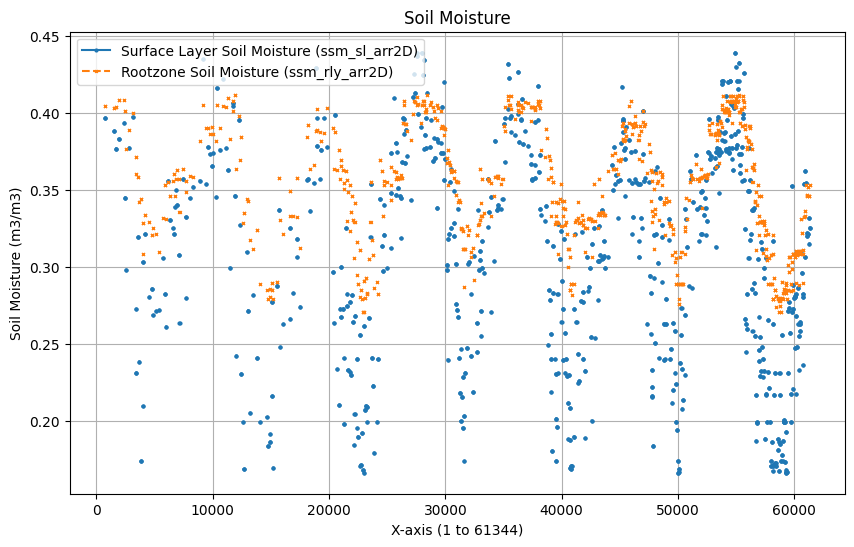

In [ ]:
# prompt: create a dot polt for ssm_sl_arr2D (surface layer soil moisture) and ssm_rly_arr2D (rootzone soil moisture)  which both have a shape of (61344, 1), x from 1 to 61344.

import matplotlib.pyplot as plt

# Assuming ssm_sl_arr2D and ssm_rly_arr2D are defined and have shape (61344, 1)
x = range(1, 61345)  # x-axis values from 1 to 61344

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(x, ssm_sl_arr2D, label='Surface Layer Soil Moisture (ssm_sl_arr2D)', marker='o', linestyle='-', markersize=2)
plt.plot(x, ssm_rly_arr2D, label='Rootzone Soil Moisture (ssm_rly_arr2D)', marker='x', linestyle='--', markersize=2)

plt.xlabel('X-axis (1 to 61344)')
plt.ylabel('Soil Moisture (m3/m3)')
plt.title('Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
ssm_sl_arr2D.shape

(61344, 1)

## Run EnKF to integrate ML estimates into a process model, Layered Green and Ampt infitration with Redistribution

Note that since LGRA model is coded in c/c++, here, the code only includes the data preparing.

### Run EnKF

In [ ]:
#@title Prepare for inputs - driving forces (precipitation and potential evaporation)
alpha = 1.3
rho_w = 1000

def e_s(T):
    return(611*np.exp((17.27*T)/(273.3+T)))

def delta(T):
    return((4098*e_s(T))/((273.3+T)**2))

def l_v(T):
    return(2500-2.36*T)

def gamma(T):
    return(66.8)
    #return(1.005*101325*pressure/(0.622*l_v(T)))
    #note that gamma is often given as the constant 66.8 pascals/decree C. the other version, commented out, takes temperature and pressure (input pressure in atm, and temp as deg C) as inputs.

def E_r(R_n,T):
    return(R_n/(l_v(T)*1000*rho_w))

def E_PT(R_n,T):
    return(E_r(R_n,T)*alpha*delta(T)/(delta(T)+gamma(T)))



prec_arr = era5hour_arr[0,:,:]*1000  # hourly precipitation, m to mm
prec_arr[prec_arr<1e-2] = 0

DSR_arr = era5hour_arr[2,:,:]/3600  # hourly DSR, J to w/m2
temp_arr = era5hour_arr[5,:,:] - 273.15  # K to degC

PET_arr = 3.6e6*E_PT(DSR_arr, temp_arr)  # hourly potential ET, mm
PET_arr[PET_arr<1e-6] = 0

np.savetxt(f"prec_arr.csv", prec_arr, delimiter=",")
np.savetxt(f"PET_arr.csv", PET_arr, delimiter=",")

In [ ]:
#@title Prepare for inputs - ML estimates
np.savetxt(f"ssm_sl_arr2D.csv", ssm_sl_arr2D, delimiter=",")
np.savetxt(f"ssm_rly_arr2D.csv", ssm_rly_arr2D, delimiter=",")
np.savetxt(f"sd_sl_arr2D.csv", sd_sl_arr2D, delimiter=",")
np.savetxt(f"sd_rly_arr2D.csv", sd_rly_arr2D, delimiter=",")

In [ ]:
#@title Prepare for inputs - soil names (USDA soil taxonomy)
pm_clay_arr = np.column_stack((clay_0_5_arr, clay_5_15_arr, clay_15_30_arr, clay_30_60_arr, clay_60_100_arr))
pm_sand_arr = np.column_stack((sand_0_5_arr, sand_5_15_arr, sand_15_30_arr, sand_30_60_arr, sand_60_100_arr))
pm_silt_arr = 100 - pm_clay_arr - pm_sand_arr

mask_sand = np.logical_and(pm_sand_arr > 85, (pm_silt_arr + 1.5 * pm_clay_arr) < 15)
mask_loamy_sand = np.logical_and.reduce([
    pm_sand_arr >= 70,
    pm_sand_arr < 91,
    (pm_silt_arr + 1.5 * pm_clay_arr) >= 15,
    (pm_silt_arr + 2 * pm_clay_arr) < 30
])
mask_sandy_loam = np.logical_or(
    np.logical_and.reduce([
        pm_clay_arr >= 7,
        pm_clay_arr < 20,
        pm_sand_arr > 52,
        (pm_silt_arr + 2 * pm_clay_arr) >= 30
    ]),
    np.logical_and.reduce([
        pm_clay_arr < 7,
        pm_silt_arr < 50,
        pm_sand_arr > 43
    ])
)
mask_loam = np.logical_and.reduce([
    pm_clay_arr >= 7,
    pm_clay_arr < 27,
    pm_silt_arr >= 28,
    pm_silt_arr < 50,
    pm_sand_arr <= 52
])
mask_silt_loam = np.logical_or(
    np.logical_and(pm_silt_arr >= 50, np.logical_and(pm_clay_arr >= 12, pm_clay_arr < 27)),
    np.logical_and(pm_clay_arr < 12, np.logical_and(pm_silt_arr >= 50, pm_silt_arr < 80))
)
mask_silt = np.logical_and(pm_silt_arr >= 80, pm_clay_arr < 12)
mask_sandy_clay_loam = np.logical_and.reduce([
    pm_clay_arr >= 20,
    pm_clay_arr < 35,
    pm_silt_arr < 28,
    pm_sand_arr > 45
])
mask_clay_loam = np.logical_and.reduce([
    pm_clay_arr >= 27,
    pm_clay_arr < 40,
    pm_sand_arr > 20,
    pm_sand_arr < 46
])
mask_silt_clay_loam = np.logical_and.reduce([
    pm_clay_arr >= 27,
    pm_clay_arr < 40,
    pm_sand_arr <= 20
])
mask_sandy_clay = np.logical_and(pm_clay_arr >= 35, pm_sand_arr >= 45)
mask_silty_clay = np.logical_and(pm_clay_arr >= 40, pm_silt_arr >= 40)
mask_clay = np.logical_and.reduce([
    pm_clay_arr >= 40,
    pm_sand_arr <= 45,
    pm_silt_arr < 40
])

#%%

soil_names_arr = np.full(pm_sand_arr.shape, 'abc', dtype='<U20')


soil_names_arr[mask_sand]="sand"

soil_names_arr[mask_loamy_sand]="loamy_sand"
soil_names_arr[mask_sandy_loam]="sandy_loam"
soil_names_arr[mask_loam]="loam"
soil_names_arr[mask_silt_loam]="silt_loam"
soil_names_arr[mask_silt]="silt"
soil_names_arr[mask_sandy_clay_loam]="sandy_clay_loam"
soil_names_arr[mask_clay_loam]="clay_loam"
soil_names_arr[mask_silt_clay_loam]="silty_clay_loam"
soil_names_arr[mask_sandy_clay]="sandy_clay"
soil_names_arr[mask_silty_clay]="silty_clay"
soil_names_arr[mask_clay]="clay"

np.savetxt(f"soil_names.csv", soil_names_arr, delimiter=",", fmt="%s")

In [ ]:
#@title compile c++ program - do it once
# !unzip LGARTOKF_forPipeline.zip -d LGARTOKF_forPipeline
# %cd LGARTOKF_forPipeline/LGARTOKF_forPipeline

# !g++ -g -std=c++17 \
# bmi_main_lgar.cxx \
# src/aet.cxx \
# src/bmi_lgar.cxx \
# src/lgar.cxx \
# src/linked_list.cxx \
# src/mem_funcs.cxx \
# src/soil_funcs.cxx \
# src/util_funcs.cxx \
# giuh/giuh.cxx \
# -Iinclude -Ibmi -Igiuh \
# -o LGAR_EnKF

# %cd /content

In [ ]:
#@title compile c++ program - do it once
# %cd /content
# !unzip LGARTOKF_original.zip -d LGARTOKF_original
# %cd LGARTOKF_original/LGARTOKF_original

# !g++ -g -std=c++17 \
# bmi_main_lgar.cxx \
# src/aet.cxx \
# src/bmi_lgar.cxx \
# src/lgar.cxx \
# src/linked_list.cxx \
# src/mem_funcs.cxx \
# src/soil_funcs.cxx \
# src/util_funcs.cxx \
# giuh/giuh.cxx \
# -Iinclude -Ibmi -Igiuh \
# -o LGAR

# %cd /content

In [ ]:
#@title run original LGAR model
!chmod +x LGAR
!./LGAR  --filename_soilname soil_names.csv --filename_prec prec_arr.csv --filename_pet PET_arr.csv --settings_path settingInfo.txt --filename_soil_params vG_default_params_HYDRUS.csv

is running site: 0
' 
          *****         
0--- Initial state/conditions --- 

[ (5.000000,0.25941350539133,1,1,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(15.000000,0.25941350539133,2,2,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(30.000000,0.25941350539133,3,3,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(60.000000,0.25941350539133,4,4,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(100.000000,0.25941350539133,5,5,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0) ] 
          *****         
------------- Initialization done! ---------------------- 
--------------------------------------------------------- 

********************************************************* 
-------------------- Simulation Summary ----------------- 
------------------------ Mass balance ------------------- 
Initial water in soil     =  25.9413505391 cm
Total precipitation       = 761.1548511124 cm
Total infiltration        = 580.3173685103 cm
Final water in soil       =  25.514908

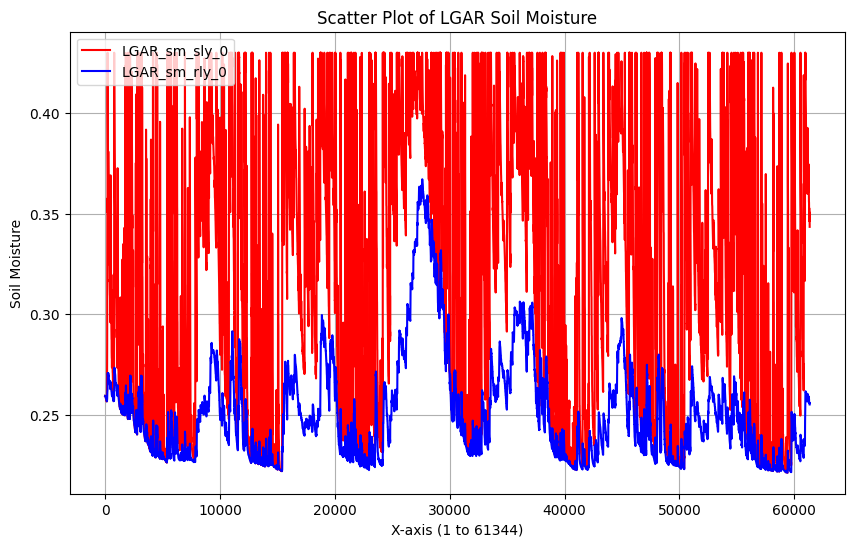

In [ ]:
# prompt: # create a scatter plot for  LGAR_sm_sly_0 and LGAR_sm_rly_0, which both have a shape of (61344, ), and x is from 1 to 61344
sm_LGAR_0 = pd.read_csv(f'Original_LGAR_{idd}.csv', header=None)
LGAR_sm_sly_0 = sm_LGAR_0.iloc[:, 1].to_numpy()
LGAR_sm_rly_0 = sm_LGAR_0.iloc[:, 2].to_numpy()

x = range(1, len(LGAR_sm_sly_0) + 1)

plt.figure(figsize=(10, 6))
plt.plot(x, LGAR_sm_sly_0, label='LGAR_sm_sly_0', color='r') #
plt.plot(x, LGAR_sm_rly_0, label='LGAR_sm_rly_0', color='b') #

plt.xlabel('X-axis (1 to 61344)')
plt.ylabel('Soil Moisture')
plt.title('Scatter Plot of LGAR Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#@title Do CDF matching: match ML to original model simulation

# ML results
sm_sl_arr2D_LGARCorrected = np.zeros(ssm_sl_arr2D.shape)
sm_rly_arr2D_LGARCorrected = np.zeros(ssm_rly_arr2D.shape)
sm_sl_arr2D_LGARCorrected[:] = np.nan
sm_rly_arr2D_LGARCorrected[:] = np.nan

for i in range(len(refer_id_arr)):
  idd = refer_id_arr[i]
  print(idd)
  # orginal models simulations
  site_sm_LGAR = pd.read_csv(f'Original_LGAR_{idd}.csv', header=None)
  LGAR_sm_sly_site = site_sm_LGAR.iloc[:, 1].to_numpy()
  LGAR_sm_rly_site = site_sm_LGAR.iloc[:, 2].to_numpy()
  print(f'LGAR at surface layer, maximum SM: {np.nanmax(LGAR_sm_sly_site)}, minimum SM: {np.nanmin(LGAR_sm_sly_site)}')
  print(f'LGAR at rootzone, maximum SM: {np.nanmax(LGAR_sm_rly_site)}, minimum SM: {np.nanmin(LGAR_sm_rly_site)}')

  # ML results

  ML_sm_sl_site = ssm_sl_arr2D[:,i]
  ML_sm_rly_site = ssm_rly_arr2D[:,i]

  print(f'ML at surface layer, maximum SM: {np.nanmax(ML_sm_sl_site)}, minimum SM: {np.nanmin(ML_sm_sl_site)}')
  print(f'ML at rootzone, maximum SM: {np.nanmax(ML_sm_rly_site)}, minimum SM: {np.nanmin(ML_sm_rly_site)}')

  nanmask_sly = np.isnan(ML_sm_sl_site)
  nanmask_rly = np.isnan(ML_sm_rly_site)

  sm_sl_arr2D_LGARCorrected[~nanmask_sly, i] = cdf_matching(ML_sm_sl_site[~nanmask_sly], LGAR_sm_sly_site)
  sm_rly_arr2D_LGARCorrected[~nanmask_rly, i] = cdf_matching(ML_sm_rly_site[~nanmask_rly], LGAR_sm_rly_site)

  print(f'cdf-ed ML at surface layer, maximum SM: {np.nanmax(sm_sl_arr2D_LGARCorrected[:,i])}, minimum SM: {np.nanmin(sm_sl_arr2D_LGARCorrected[:,i])}')
  print(f'cdf-ed ML at rootzone, maximum SM: {np.nanmax(sm_rly_arr2D_LGARCorrected[:,i])}, minimum SM: {np.nanmin(sm_rly_arr2D_LGARCorrected[:,i])}')


np.savetxt(f"sm_sl_arr2D_LGARCorrected.csv", sm_sl_arr2D_LGARCorrected, delimiter=",")
np.savetxt(f"sm_rly_arr2D_LGARCorrected.csv", sm_rly_arr2D_LGARCorrected, delimiter=",")



0
LGAR at surface layer, maximum SM: 0.43, minimum SM: 0.22121
LGAR at rootzone, maximum SM: 0.367089, minimum SM: 0.22121
ML at surface layer, maximum SM: 0.43922746181488037, minimum SM: 0.16619305312633514
ML at rootzone, maximum SM: 0.4117368757724762, minimum SM: 0.2705167829990387
cdf-ed ML at surface layer, maximum SM: 0.43, minimum SM: 0.22168976690888764
cdf-ed ML at rootzone, maximum SM: 0.3633916697494792, minimum SM: 0.2216519660890628


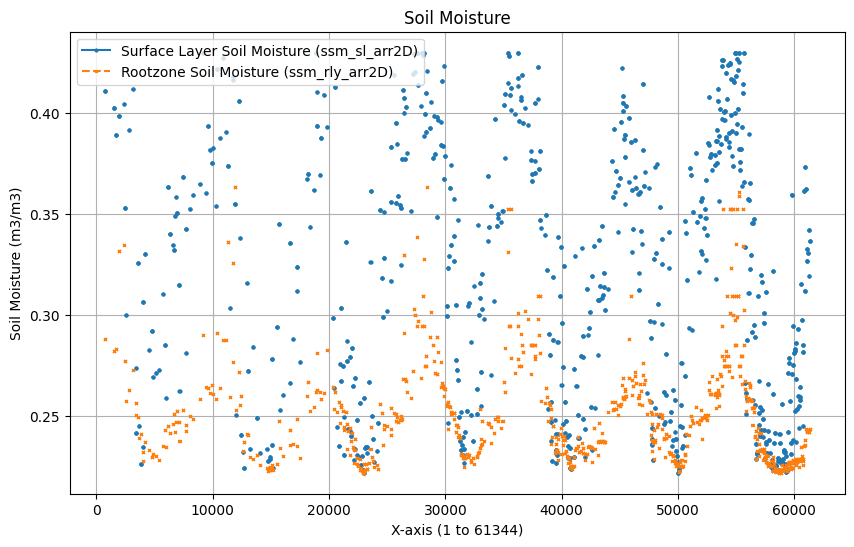

In [ ]:
import matplotlib.pyplot as plt

# Assuming ssm_sl_arr2D and ssm_rly_arr2D are defined and have shape (61344, 1)
x = range(1, 61345)  # x-axis values from 1 to 61344

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(x, sm_sl_arr2D_LGARCorrected, label='Surface Layer Soil Moisture (ssm_sl_arr2D)', marker='o', linestyle='-', markersize=2)
plt.plot(x, sm_rly_arr2D_LGARCorrected, label='Rootzone Soil Moisture (ssm_rly_arr2D)', marker='x', linestyle='--', markersize=2)

plt.xlabel('X-axis (1 to 61344)')
plt.ylabel('Soil Moisture (m3/m3)')
plt.title('Soil Moisture')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#@title run EnKF-LGAR
!chmod +x LGAR_EnKF
!./LGAR_EnKF --filename_soilname soil_names.csv --filename_prec prec_arr.csv --filename_pet PET_arr.csv --filename_sm_sly sm_sl_arr2D_LGARCorrected.csv --filename_sm_rly sm_rly_arr2D_LGARCorrected.csv --filename_sd_sly sd_sl_arr2D.csv --filename_sd_rly sd_rly_arr2D.csv --settings_path settingInfo.txt  --filename_soil_params vG_default_params_HYDRUS.csv

61344
is running site: 0
' 
          *****         
0--- Initial state/conditions --- 

[ (5.000000,0.25941350539133,1,1,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(15.000000,0.25941350539133,2,2,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(30.000000,0.25941350539133,3,3,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(60.000000,0.25941350539133,4,4,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(100.000000,0.25941350539133,5,5,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0) ] 
          *****         
------------- Initialization done! ---------------------- 
--------------------------------------------------------- 
' 
          *****         
0--- Initial state/conditions --- 

[ (5.000000,0.25941350539133,1,1,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(15.000000,0.25941350539133,2,2,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(30.000000,0.25941350539133,3,3,1, 0.000000e+00, 0.000001, 2000.00000000000000, 0)
(60.000000,0.25941350539133,4,4,1,

In [ ]:
# @title CDF match back to ML estimates
for i in range(len(refer_id_arr)):
  idd = refer_id_arr[i]
  print(idd)
  df_enkf = pd.read_csv(f'EnKF_LGAR_{idd}.csv')
  # ML results
  ML_sm_sl_site = ssm_sl_arr2D[:,i]
  ML_sm_rly_site = ssm_rly_arr2D[:,i]
  nanmask_sly = np.isnan(ML_sm_sl_site)
  nanmask_rly = np.isnan(ML_sm_rly_site)

  df_enkf['ml_sm_sly'] = ML_sm_sl_site
  df_enkf['ml_sm_rly'] = ML_sm_rly_site

  df_enkf['forcast_sm_sly'] = cdf_matching(df_enkf['forcast_sm_sly'].to_numpy(), ML_sm_sl_site[~nanmask_rly])
  df_enkf['forcast_sm_rly'] = cdf_matching(df_enkf['forcast_sm_rly'].to_numpy(), ML_sm_rly_site[~nanmask_rly])
  df_enkf['analysis_sm_sly'] = cdf_matching(df_enkf['analysis_sm_sly'].to_numpy(), ML_sm_sl_site[~nanmask_rly])
  df_enkf['analysis_sm_rly'] = cdf_matching(df_enkf['analysis_sm_rly'].to_numpy(), ML_sm_rly_site[~nanmask_rly])

  df_enkf.to_csv(f'EnKF_LGAR_{idd}.csv', index=False)



0


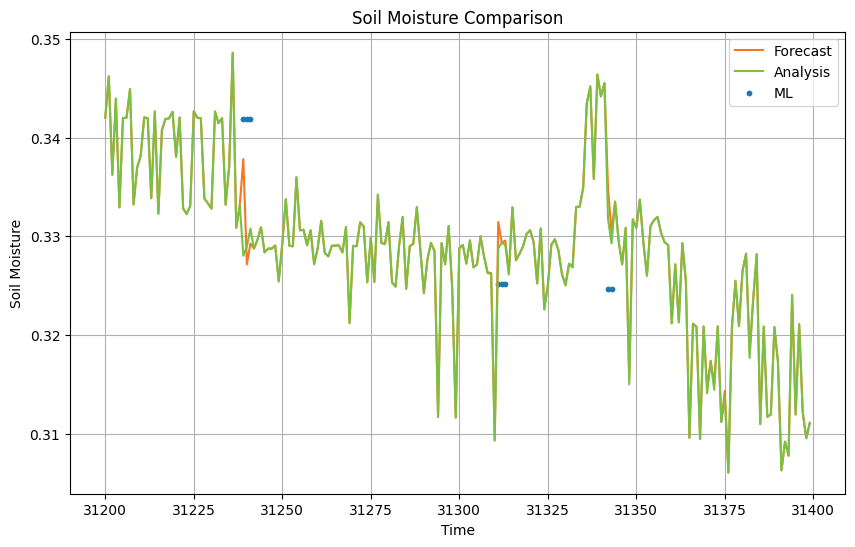

In [ ]:
# prompt: create a plot:
# x=df_enkf['time']
# y1=df_enkf['forcast_sm_rly'], whic is a line
# y2=df_enkf['analysis_sm_rly'], whic is a line
# y3=df_enkf['ml_sm_rly'], whic is a scatter

df_enkf = pd.read_csv(f'EnKF_LGAR_0.csv')
x = df_enkf['time'].to_numpy()
y1 = df_enkf['forcast_sm_rly'].to_numpy()
y1_sigma = df_enkf['forcast_sd_rly'].to_numpy()
y1_upper = y1 + y1_sigma
y1_lower = y1 - y1_sigma
y2 = df_enkf['analysis_sm_rly'].to_numpy()
y2_sigma = df_enkf['analysis_sd_rly'].to_numpy()
y2_upper = y2 + y2_sigma
y2_lower = y2 - y2_sigma
y3 = df_enkf['ml_sm_rly'].to_numpy()
y3_sigma = df_enkf['ml_sd_rly'].to_numpy()
y3_upper = y3 + y3_sigma
y3_lower = y3 - y3_sigma

plt.figure(figsize=(10, 6))
plt.plot(x[31200:31400], y1[31200:31400], label='Forecast', color='#f47721')
plt.plot(x[31200:31400], y2[31200:31400], label='Analysis', color='#7ac143')
plt.scatter(x[31200:31400], y3[31200:31400], label='ML', marker='o', s=10) # Adjust marker size (s) as needed

plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture Comparison')
plt.legend()
plt.grid(True)
plt.show()


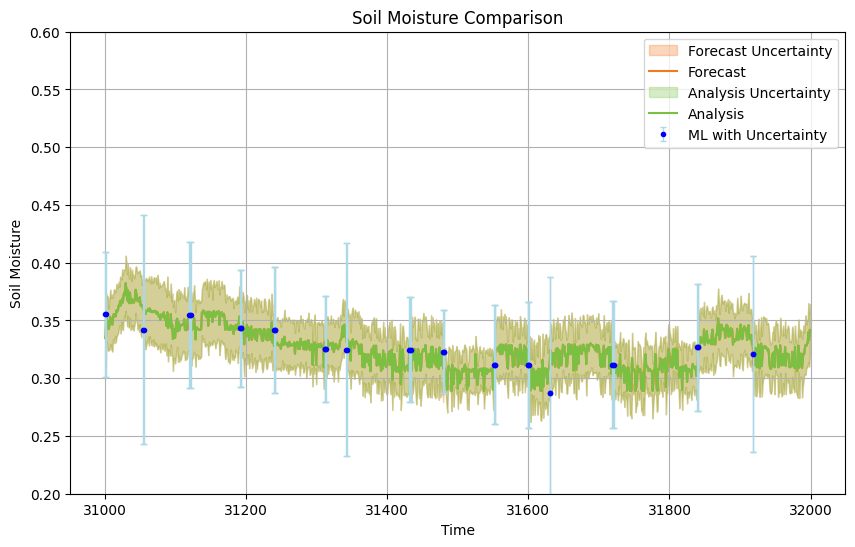

In [ ]:
#@title plot with uncertainty

# Load data
df_enkf = pd.read_csv('EnKF_LGAR_0.csv')

# Define range for slicing
range_low = 31000    # Change this to set the start index
range_up = 32000   # Change this to set the end index

# Slice x and all y variables
x = df_enkf['time'].to_numpy()[range_low:range_up]
y1 = df_enkf['forcast_sm_rly'].to_numpy()[range_low:range_up]
y1_sigma = df_enkf['forcast_sd_rly'].to_numpy()[range_low:range_up]
y1_upper = y1 + y1_sigma
y1_lower = y1 - y1_sigma

y2 = df_enkf['analysis_sm_rly'].to_numpy()[range_low:range_up]
y2_sigma = df_enkf['analysis_sd_rly'].to_numpy()[range_low:range_up]
y2_upper = y2 + y2_sigma
y2_lower = y2 - y2_sigma

y3 = df_enkf['ml_sm_rly'].to_numpy()[range_low:range_up]
y3_sigma = df_enkf['ml_sd_rly'].to_numpy()[range_low:range_up]
y3_upper = y3 + y3_sigma
y3_lower = y3 - y3_sigma

# Plotting
plt.figure(figsize=(10, 6))

plt.fill_between(x, y1_upper, y1_lower, color='#f47721', alpha=0.3, label='Forecast Uncertainty')
plt.plot(x, y1, color='#f47721', label='Forecast')

plt.fill_between(x, y2_upper, y2_lower, color='#7ac143', alpha=0.3, label='Analysis Uncertainty')
plt.plot(x, y2, color='#7ac143', label='Analysis')

plt.errorbar(
    x, y3,
    yerr=[y3 - y3_lower, y3_upper - y3],
    fmt='o',
    color='blue',
    ecolor='lightblue',
    elinewidth=1,
    # alpha=0.5,
    markersize=3,
    capsize=2,
    label='ML with Uncertainty'
)

plt.xlabel('Time')
plt.ylabel('Soil Moisture')
plt.title('Soil Moisture Comparison')
plt.ylim(0.2, 0.6)
plt.legend()
plt.grid(True)
plt.show()

